In [5]:
for key in data.files:
    arr = data[key]
    n_unique = np.unique(arr).size
    print(f"{key}: {n_unique} unique samples")


mean: 4 unique samples
sigma: 4 unique samples
vel_sigma: 4 unique samples


# Sampling method for posterior distribution

In [6]:
!nvidia-smi

Wed May 28 14:23:44 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      Off| 00000000:1A:00.0 Off |                  N/A |
| 16%   27C    P8                1W / 250W|     18MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' #change to the GPU you want to use

# Simulation pipeline

## Dynamic of particules

In [8]:
import jax.numpy as jnp 
import jax
jax.config.update("jax_debug_nans", True) # notice if there are any nans immediately
from jax import vmap, random 
import matplotlib.pyplot as plt
import numpy as np
from diffrax import diffeqsolve, ODETerm, Dopri5,LeapfrogMidpoint, SaveAt
from jaxpm.painting import cic_paint, cic_read


In [9]:
@jax.jit 
def pairwise_forces(pos, G, softening, length):
    # dx_ij = pos_i - pos_j with minimal-image, branchless
    dx = pos[:,None,:] - pos[None,:,:]           # (N,N,3)
    dx = dx - length*jnp.round(dx/length)                  # periodic, no comparison so better for XLA
    r2 = jnp.sum(dx**2, axis=-1) + softening**2           # (N,N)
    inv_r3 = jnp.where(jnp.eye(pos.shape[0]), 0., r2**-1.5)
    F = jnp.einsum('ij,ijc->ic', inv_r3, dx)  # (N,3)
    F = -G*F
    return F

In [10]:
def make_diffrax_ode(softening,
               G, length):

    def nbody_ode(t,state,args):
        """
        state is a tuple (position, velocities)
        """
        pos, vel  = state

        forces = pairwise_forces(pos, G=G, softening=softening, length=length)


        # Computes the update of position (drift)
        dpos = vel

        # Computes the update of velocity (kick)
        dvel = forces
        return jnp.stack([dpos, dvel]) # stack to get (2, N, 3) shape

    return nbody_ode

## Plot functions

In [11]:
def plot_density_fields_and_positions(G, tf, dt, length, n_part, input_field, init_pos, final_pos, output_field):
    """
    Plot density fields and particle positions in various projections.
    
    Parameters:
    -----------
    input_field : array
        The input density field (3D array)
    init_pos : array
        Initial particle positions (N x 3 array)
    final_pos : array
        Final particle positions (N x 3 array)
    output_field : array
        The output density field (3D array)
    """
    # Create figure with a grid layout
    fig = plt.figure(figsize=(25, 20))
    gs = plt.GridSpec(4, 4, figure=fig)

    title = 'Simulation with parameters:'
    param_info = f'G={G}, tf={tf}, dt={dt}, L={length}, N={n_part}'
    title += f'\n{param_info}'
    fig.suptitle(title, y=1.0, fontsize=22)
    
    # First row: Input density field (3 plots)
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(jnp.sum(input_field, axis=0), cmap='inferno')
    ax1.set_title('Input Density Field (Projection X-Y)')
    fig.colorbar(im1, ax=ax1, orientation='vertical')

    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(jnp.sum(input_field, axis=1), cmap='inferno')
    ax2.set_title('Input Density Field (Projection X-Z)')
    fig.colorbar(im2, ax=ax2, orientation='vertical')

    ax3 = fig.add_subplot(gs[0, 2])
    im3 = ax3.imshow(jnp.sum(input_field, axis=2), cmap='inferno')
    ax3.set_title('Input Density Field (Projection Y-Z)')
    fig.colorbar(im3, ax=ax3, orientation='vertical')
    
    # Empty plot in top-right corner
    fig.add_subplot(gs[0, 3]).set_visible(False)

    # Second row: Initial positions (4 plots)
    ax4 = fig.add_subplot(gs[1, 0], projection='3d')
    ax4.scatter(init_pos[:, 0], init_pos[:, 1], init_pos[:, 2], c='r', marker='o', alpha=0.5, s=1)
    ax4.set_title('Initial Particle Positions (3D)')
    ax4.set_xlabel('X'); ax4.set_ylabel('Y'); ax4.set_zlabel('Z')

    ax5 = fig.add_subplot(gs[1, 1])
    ax5.scatter(init_pos[:, 0], init_pos[:, 1], c='r', marker='o', alpha=0.5, s=1)
    ax5.set_title('Initial Positions (X-Y)')
    ax5.set_xlabel('X'); ax5.set_ylabel('Y')

    ax6 = fig.add_subplot(gs[1, 2])
    ax6.scatter(init_pos[:, 0], init_pos[:, 2], c='r', marker='o', alpha=0.5, s=1)
    ax6.set_title('Initial Positions (X-Z)')
    ax6.set_xlabel('X'); ax6.set_ylabel('Z')

    ax7 = fig.add_subplot(gs[1, 3])
    ax7.scatter(init_pos[:, 1], init_pos[:, 2], c='r', marker='o', alpha=0.5, s=1)
    ax7.set_title('Initial Positions (Y-Z)')
    ax7.set_xlabel('Y'); ax7.set_ylabel('Z')

    # Third row: Final positions (4 plots)
    ax8 = fig.add_subplot(gs[2, 0], projection='3d')
    ax8.scatter(final_pos[:, 0], final_pos[:, 1], final_pos[:, 2], c='b', marker='o', alpha=0.5, s=1)
    ax8.set_title('Final Particle Positions (3D)')
    ax8.set_xlabel('X'); ax8.set_ylabel('Y'); ax8.set_zlabel('Z')

    ax9 = fig.add_subplot(gs[2, 1])
    ax9.scatter(final_pos[:, 0], final_pos[:, 1], c='b', marker='o', alpha=0.5, s=1)
    ax9.set_title('Final Positions (X-Y)')
    ax9.set_xlabel('X'); ax9.set_ylabel('Y')

    ax10 = fig.add_subplot(gs[2, 2])
    ax10.scatter(final_pos[:, 0], final_pos[:, 2], c='b', marker='o', alpha=0.5, s=1)
    ax10.set_title('Final Positions (X-Z)')
    ax10.set_xlabel('X'); ax10.set_ylabel('Z')

    ax11 = fig.add_subplot(gs[2, 3])
    ax11.scatter(final_pos[:, 1], final_pos[:, 2], c='b', marker='o', alpha=0.5, s=1)
    ax11.set_title('Final Positions (Y-Z)')
    ax11.set_xlabel('Y'); ax11.set_ylabel('Z')

    # Fourth row: Output density field (3 plots)
    ax12 = fig.add_subplot(gs[3, 0])
    im12 = ax12.imshow(jnp.sum(output_field, axis=0), cmap='inferno')
    ax12.set_title('Output Density Field (Projection X-Y)')
    fig.colorbar(im12, ax=ax12, orientation='vertical')

    ax13 = fig.add_subplot(gs[3, 1])
    im13 = ax13.imshow(jnp.sum(output_field, axis=1), cmap='inferno')
    ax13.set_title('Output Density Field (Projection X-Z)')
    fig.colorbar(im13, ax=ax13, orientation='vertical')

    ax14 = fig.add_subplot(gs[3, 2])
    im14 = ax14.imshow(jnp.sum(output_field, axis=2), cmap='inferno')
    ax14.set_title('Output Density Field (Projection Y-Z)')
    fig.colorbar(im14, ax=ax14, orientation='vertical')
    
    # Empty plot in bottom-right corner
    fig.add_subplot(gs[3, 3]).set_visible(False)

    plt.tight_layout()
    plt.show()
    return fig


In [7]:
def plot_all_timesteps(sol,
                       boxL,
                       G,    
                       tf,
                       dt,
                       n_part,
                       skip=1,            # save memory: plot every 'skip'-th step
                       s=1,               # marker size for scatters
                       cmap='inferno'):
    """
    Parameters
    ----------
    sol   : diffrax solution object  (ys shape = (T, 2, N, 3))
    boxL  : box length used in cic_paint
    skip  : int, plot every `skip`-th stored step
    s     : matplotlib scatter size
    """
    # How many rows will we draw?
    steps = sol.ts[::skip]       # time steps to plot
    nrows = len(steps)

    # Pre-build the canvas
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=4,
                             figsize=(24, 4 * nrows),
                             squeeze=False)
    
    # Add global title with simulation parameters
    title = 'Simulation with parameters:'
    param_info = f'G={G}, tf={tf}, dt={dt}, L={boxL}, N={n_part}'
    title += f'\n{param_info}'
    fig.suptitle(title, y=1.0, fontsize=22)

    for row, t in enumerate(steps): 
        # Check if sol.ys is a tuple (central mass case) or array (first simulation)
        if isinstance(sol.ys, tuple):
            pos_t = sol.ys[0][row]  # For tuple format: (positions, velocities)
        else:
            pos_t = sol.ys[row][0]
        # --- projections ----------------------------------------------------
        axes[row, 0].scatter(pos_t[:, 0], pos_t[:, 1], s=s)
        axes[row, 1].scatter(pos_t[:, 0], pos_t[:, 2], s=s)
        axes[row, 2].scatter(pos_t[:, 1], pos_t[:, 2], s=s)

        for col, lbl in zip(range(3),
                            ['XY', 'XZ', 'YZ']):
            ax = axes[row, col]
            ax.set_title(f't={t:.2f}  ({lbl})')
            ax.set_xlabel(lbl[0]); ax.set_ylabel(lbl[1])
            ax.set_xlim(0, boxL);  ax.set_ylim(0, boxL)

        # --- density slice --------------------------------------------------
        field_t = cic_paint(jnp.zeros((boxL, boxL, boxL)), pos_t)
        im = axes[row, 3].imshow(jnp.sum(field_t, axis=2),
                                 cmap=cmap, origin='lower')
        axes[row, 3].set_title('Σ ρ(x,y)')
        fig.colorbar(im, ax=axes[row, 3], orientation='vertical')

    plt.tight_layout()
    plt.show()
    return fig, axes

In [8]:
def plot_trajectories(solution, G, tf, dt, length, n_part, particle_indices=None, box=None, title=None, figsize=(20, 5), zoom=True, padding=0.1, smooth_window=5, arrow_frac=0.7):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np

    def smooth_trajectory(traj, window):
        if window < 2:
            return traj
        kernel = np.ones(window) / window
        traj_padded = np.pad(traj, ((window//2, window-1-window//2), (0,0)), mode='edge')
        smoothed = np.vstack([
            np.convolve(traj_padded[:, dim], kernel, mode='valid')
            for dim in range(traj.shape[1])
        ]).T
        return smoothed

    if isinstance(solution.ys, tuple):
        positions = solution.ys[0]
    else:
        positions = solution.ys[:, 0]
    n_timesteps, n_particles, n_dims = positions.shape

    if particle_indices is None:
        if n_particles > 50:
            particle_indices = np.random.choice(n_particles, 50, replace=False)
        else:
            particle_indices = np.arange(n_particles)

    fig = plt.figure(figsize=figsize)
    ax_3d = fig.add_subplot(1, 4, 1, projection='3d')
    ax_xy = fig.add_subplot(1, 4, 2)
    ax_xz = fig.add_subplot(1, 4, 3)
    ax_yz = fig.add_subplot(1, 4, 4)

    # Create parameter info string
    param_info = f'G={G}, tf={tf}, dt={dt}, L={length}, N={n_part}'
    if title:
        title = f'{title}\n{param_info}'
    else:
        title = param_info

    ax_3d.set_title('3D Trajectories (Smoothed)')
    ax_xy.set_title('XY Projection')
    ax_xz.set_title('XZ Projection')
    ax_yz.set_title('YZ Projection')

    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')
    ax_xy.set_xlabel('X')
    ax_xy.set_ylabel('Y')
    ax_xz.set_xlabel('X')
    ax_xz.set_ylabel('Z')
    ax_yz.set_xlabel('Y')
    ax_yz.set_ylabel('Z')

    # Plot final positions of all particles in background with transparency
    final_pos_all = positions[-1, :]
    ax_3d.scatter(final_pos_all[:, 0], final_pos_all[:, 1], final_pos_all[:, 2], 
                  color='lightgray', alpha=0.4, s=5)
    ax_xy.scatter(final_pos_all[:, 0], final_pos_all[:, 1], color='lightgray', alpha=0.2, s=5)
    ax_xz.scatter(final_pos_all[:, 0], final_pos_all[:, 2], color='lightgray', alpha=0.2, s=5)
    ax_yz.scatter(final_pos_all[:, 1], final_pos_all[:, 2], color='lightgray', alpha=0.2, s=5)

    colors = plt.cm.jet(np.linspace(0, 1, len(particle_indices)))
    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')
    z_min, z_max = float('inf'), float('-inf')

    for i, p_idx in enumerate(particle_indices):
        traj = positions[:, p_idx]
        traj_smooth = smooth_trajectory(traj, window=smooth_window)
        x_min = min(x_min, traj_smooth[:, 0].min())
        x_max = max(x_max, traj_smooth[:, 0].max())
        y_min = min(y_min, traj_smooth[:, 1].min())
        y_max = max(y_max, traj_smooth[:, 1].max())
        z_min = min(z_min, traj_smooth[:, 2].min())
        z_max = max(z_max, traj_smooth[:, 2].max())
        ax_3d.plot(traj_smooth[:, 0], traj_smooth[:, 1], traj_smooth[:, 2], color=colors[i], linewidth=1.0, alpha=0.7)
        ax_xy.plot(traj_smooth[:, 0], traj_smooth[:, 1], color=colors[i], linewidth=1.0)
        ax_xz.plot(traj_smooth[:, 0], traj_smooth[:, 2], color=colors[i], linewidth=1.0)
        ax_yz.plot(traj_smooth[:, 1], traj_smooth[:, 2], color=colors[i], linewidth=1.0)
        ax_3d.scatter(traj_smooth[0, 0], traj_smooth[0, 1], traj_smooth[0, 2], color=colors[i], marker='o', s=20)
        ax_3d.scatter(traj_smooth[-1, 0], traj_smooth[-1, 1], traj_smooth[-1, 2], color=colors[i], marker='s', s=20)

        # Add arrows to indicate direction (at arrow_frac along the trajectory)
        idx = int(len(traj_smooth) * arrow_frac)
        if idx < len(traj_smooth) - 1:
            # 3D arrow
            ax_3d.quiver(
                traj_smooth[idx, 0], traj_smooth[idx, 1], traj_smooth[idx, 2],
                traj_smooth[idx+1, 0] - traj_smooth[idx, 0],
                traj_smooth[idx+1, 1] - traj_smooth[idx, 1],
                traj_smooth[idx+1, 2] - traj_smooth[idx, 2],
                color=colors[i], arrow_length_ratio=0.3, linewidth=1.5, alpha=0.8
            )
            # 2D arrows
            ax_xy.annotate('', xy=(traj_smooth[idx+1, 0], traj_smooth[idx+1, 1]), 
                           xytext=(traj_smooth[idx, 0], traj_smooth[idx, 1]),
                           arrowprops=dict(facecolor=colors[i], edgecolor=colors[i], arrowstyle='->', lw=1.5, alpha=0.8))
            ax_xz.annotate('', xy=(traj_smooth[idx+1, 0], traj_smooth[idx+1, 2]), 
                           xytext=(traj_smooth[idx, 0], traj_smooth[idx, 2]),
                           arrowprops=dict(facecolor=colors[i], edgecolor=colors[i], arrowstyle='->', lw=1.5, alpha=0.8))
            ax_yz.annotate('', xy=(traj_smooth[idx+1, 1], traj_smooth[idx+1, 2]), 
                           xytext=(traj_smooth[idx, 1], traj_smooth[idx, 2]),
                           arrowprops=dict(facecolor=colors[i], edgecolor=colors[i], arrowstyle='->', lw=1.5, alpha=0.8))

    if zoom:
        x_range = max(x_max - x_min, 1e-10)
        y_range = max(y_max - y_min, 1e-10)
        z_range = max(z_max - z_min, 1e-10)
        x_padding = padding * x_range
        y_padding = padding * y_range
        z_padding = padding * z_range
        ax_3d.set_xlim([x_min - x_padding, x_max + x_padding])
        ax_3d.set_ylim([y_min - y_padding, y_max + y_padding])
        ax_3d.set_zlim([z_min - z_padding, z_max + z_padding])
        ax_xy.set_xlim([x_min - x_padding, x_max + x_padding])
        ax_xy.set_ylim([y_min - y_padding, y_max + y_padding])
        ax_xz.set_xlim([x_min - x_padding, x_max + x_padding])
        ax_xz.set_ylim([z_min - z_padding, z_max + z_padding])
        ax_yz.set_xlim([y_min - y_padding, y_max + y_padding])
        ax_yz.set_ylim([z_min - z_padding, z_max + z_padding])
    elif box is not None:
        ax_3d.set_xlim([0, length])
        ax_3d.set_ylim([0, length])
        ax_3d.set_zlim([0, length])
        ax_xy.set_xlim([0, length])
        ax_xy.set_ylim([0, length])
        ax_xz.set_xlim([0, length])
        ax_xz.set_ylim([0, length])
        ax_yz.set_xlim([0, length])
        ax_yz.set_ylim([0, length])

    ax_xy.grid(True)
    ax_xz.grid(True)
    ax_yz.grid(True)
    if title:
        fig.suptitle(title, fontsize=16)
    start_marker = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8, label='Start')
    end_marker = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='k', markersize=8, label='End')
    background_marker = plt.Line2D([0], [0], marker='o', color='lightgray', markersize=8, label='All Particles')
    ax_3d.legend(handles=[start_marker, end_marker, background_marker], loc='upper right')
    plt.tight_layout()
    return fig

In [9]:
def plot_velocity_distributions(sol, G, tf, dt, length, n_part):
    # Calculate velocity norms for initial and final velocities
    init_vel = sol.ys[0, 1]  # Initial velocities
    init_vel_norm = jnp.sqrt(jnp.sum(init_vel**2, axis=1))
    final_vel = sol.ys[-1, 1]  # Final velocities
    final_vel_norm = jnp.sqrt(jnp.sum(final_vel**2, axis=1))

    # Create a figure with 2 rows and 4 columns
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    title = 'Velocity Distribution Comparison with parameters:'
    param_info = f'G={G}, tf={tf}, dt={dt}, L={length}, N={n_part}'
    title += f'\n{param_info}'
    fig.suptitle(title, y=1.05, fontsize=22)

    # First row - Initial velocities
    # Histogram of velocity magnitudes
    axes[0, 0].hist(init_vel_norm, bins=50, color='blue', alpha=0.7, density=True)
    axes[0, 0].set_xlabel('Velocity Magnitude', fontsize=12)
    axes[0, 0].set_ylabel('Density', fontsize=12)
    axes[0, 0].set_title('Initial Velocity Magnitudes', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].text(0.05, 0.95, 
        f"Mean={jnp.mean(init_vel_norm):.2f}\nStd={jnp.std(init_vel_norm):.2f}",
        transform=axes[0, 0].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    # Histograms for vx, vy, vz components of initial velocities
    axes[0, 1].hist(init_vel[:, 0], bins=50, color='blue', alpha=0.7, density=True)
    axes[0, 1].set_xlabel('Vx', fontsize=12)
    axes[0, 1].set_ylabel('Density', fontsize=12)
    axes[0, 1].set_title('Initial Vx Distribution', fontsize=14)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].text(0.05, 0.95, 
        f"Mean={jnp.mean(init_vel[:, 0]):.2f}\nStd={jnp.std(init_vel[:, 0]):.2f}",
        transform=axes[0, 1].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    axes[0, 2].hist(init_vel[:, 1], bins=50, color='blue', alpha=0.7, density=True)
    axes[0, 2].set_xlabel('Vy', fontsize=12)
    axes[0, 2].set_ylabel('Density', fontsize=12)
    axes[0, 2].set_title('Initial Vy Distribution', fontsize=14)
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].text(0.05, 0.95, 
        f"Mean={jnp.mean(init_vel[:, 1]):.2f}\nStd={jnp.std(init_vel[:, 1]):.2f}",
        transform=axes[0, 2].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    axes[0, 3].hist(init_vel[:, 2], bins=50, color='blue', alpha=0.7, density=True)
    axes[0, 3].set_xlabel('Vz', fontsize=12)
    axes[0, 3].set_ylabel('Density', fontsize=12)
    axes[0, 3].set_title('Initial Vz Distribution', fontsize=14)
    axes[0, 3].grid(True, alpha=0.3)
    axes[0, 3].text(0.05, 0.95, 
        f"Mean={jnp.mean(init_vel[:, 2]):.2f}\nStd={jnp.std(init_vel[:, 2]):.2f}",
        transform=axes[0, 3].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    # Second row - Final velocities
    # Histogram of velocity magnitudes
    axes[1, 0].hist(final_vel_norm, bins=50, color='red', alpha=0.7, density=True)
    axes[1, 0].set_xlabel('Velocity Magnitude', fontsize=12)
    axes[1, 0].set_ylabel('Density', fontsize=12)
    axes[1, 0].set_title('Final Velocity Magnitudes', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].text(0.05, 0.95, 
        f"Mean={jnp.mean(final_vel_norm):.2f}\nStd={jnp.std(final_vel_norm):.2f}",
        transform=axes[1, 0].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    # Histograms for vx, vy, vz components of final velocities
    axes[1, 1].hist(final_vel[:, 0], bins=50, color='red', alpha=0.7, density=True)
    axes[1, 1].set_xlabel('Vx', fontsize=12)
    axes[1, 1].set_ylabel('Density', fontsize=12)
    axes[1, 1].set_title('Final Vx Distribution', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].text(0.05, 0.95, 
        f"Mean={jnp.mean(final_vel[:, 0]):.2f}\nStd={jnp.std(final_vel[:, 0]):.2f}",
        transform=axes[1, 1].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    axes[1, 2].hist(final_vel[:, 1], bins=50, color='red', alpha=0.7, density=True)
    axes[1, 2].set_xlabel('Vy', fontsize=12)
    axes[1, 2].set_ylabel('Density', fontsize=12)
    axes[1, 2].set_title('Final Vy Distribution', fontsize=14)
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].text(0.05, 0.95, 
        f"Mean={jnp.mean(final_vel[:, 1]):.2f}\nStd={jnp.std(final_vel[:, 1]):.2f}",
        transform=axes[1, 2].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    axes[1, 3].hist(final_vel[:, 2], bins=50, color='red', alpha=0.7, density=True)
    axes[1, 3].set_xlabel('Vz', fontsize=12)
    axes[1, 3].set_ylabel('Density', fontsize=12)
    axes[1, 3].set_title('Final Vz Distribution', fontsize=14)
    axes[1, 3].grid(True, alpha=0.3)
    axes[1, 3].text(0.05, 0.95, 
        f"Mean={jnp.mean(final_vel[:, 2]):.2f}\nStd={jnp.std(final_vel[:, 2]):.2f}",
        transform=axes[1, 3].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust for the suptitle
    plt.show()
    
    return fig, axes


## Forward model

Mock dataset : gaussian for positions and centered gaussian for velocities

In [10]:
key = jax.random.PRNGKey(0)
n_part = 1_000
theta  = dict(pos_std=10.0, pos_mean=30.0, vel_std=1.0)

init_pos = jax.random.normal(key, (n_part, 3))*theta["pos_std"] + theta["pos_mean"]
init_vel = jax.random.normal(key, (n_part, 3))*theta["vel_std"]
y0       = jnp.stack([init_pos, init_vel])          # (2,N,3)

KeyboardInterrupt: 

In [11]:
# Parameters for the simulation
length = 64
G = 5
softening = 10**-1
t_f = 1.0
dt = 0.5
ts = jnp.linspace(0, t_f, 10)
skip = ts.shape[0] // 10

key = jax.random.PRNGKey(0)
n_part = 1_000
theta  = dict(pos_std=10.0, pos_mean=30.0, vel_std=1.0)

In [12]:
# Initialize positions and velocities of our mock data
init_pos = jax.random.normal(key, (n_part, 3))*theta["pos_std"] + theta["pos_mean"]
init_vel = jax.random.normal(key, (n_part, 3))*theta["vel_std"]
y0       = jnp.stack([init_pos, init_vel])          # (2,N,3)
input_field = cic_paint(jnp.zeros((length, length, length)), init_pos)

In [13]:
term = ODETerm(make_diffrax_ode(softening=softening, G=G, length=length))
solver = LeapfrogMidpoint()

In [14]:
sol = diffeqsolve(term, solver, t0=0, t1=t_f, dt0=dt, y0=y0, saveat = SaveAt(ts=ts))

# Final positions
final_pos = sol.ys[-1, 0]     # positions at final time (t=1)
output_field = cic_paint(jnp.zeros((length, length, length)), final_pos)

sigma_n_true = 0.05 * jnp.std(output_field)
noise_key = jax.random.PRNGKey(2025)
noise = sigma_n_true * jax.random.normal(noise_key, output_field.shape)
data   = output_field + noise

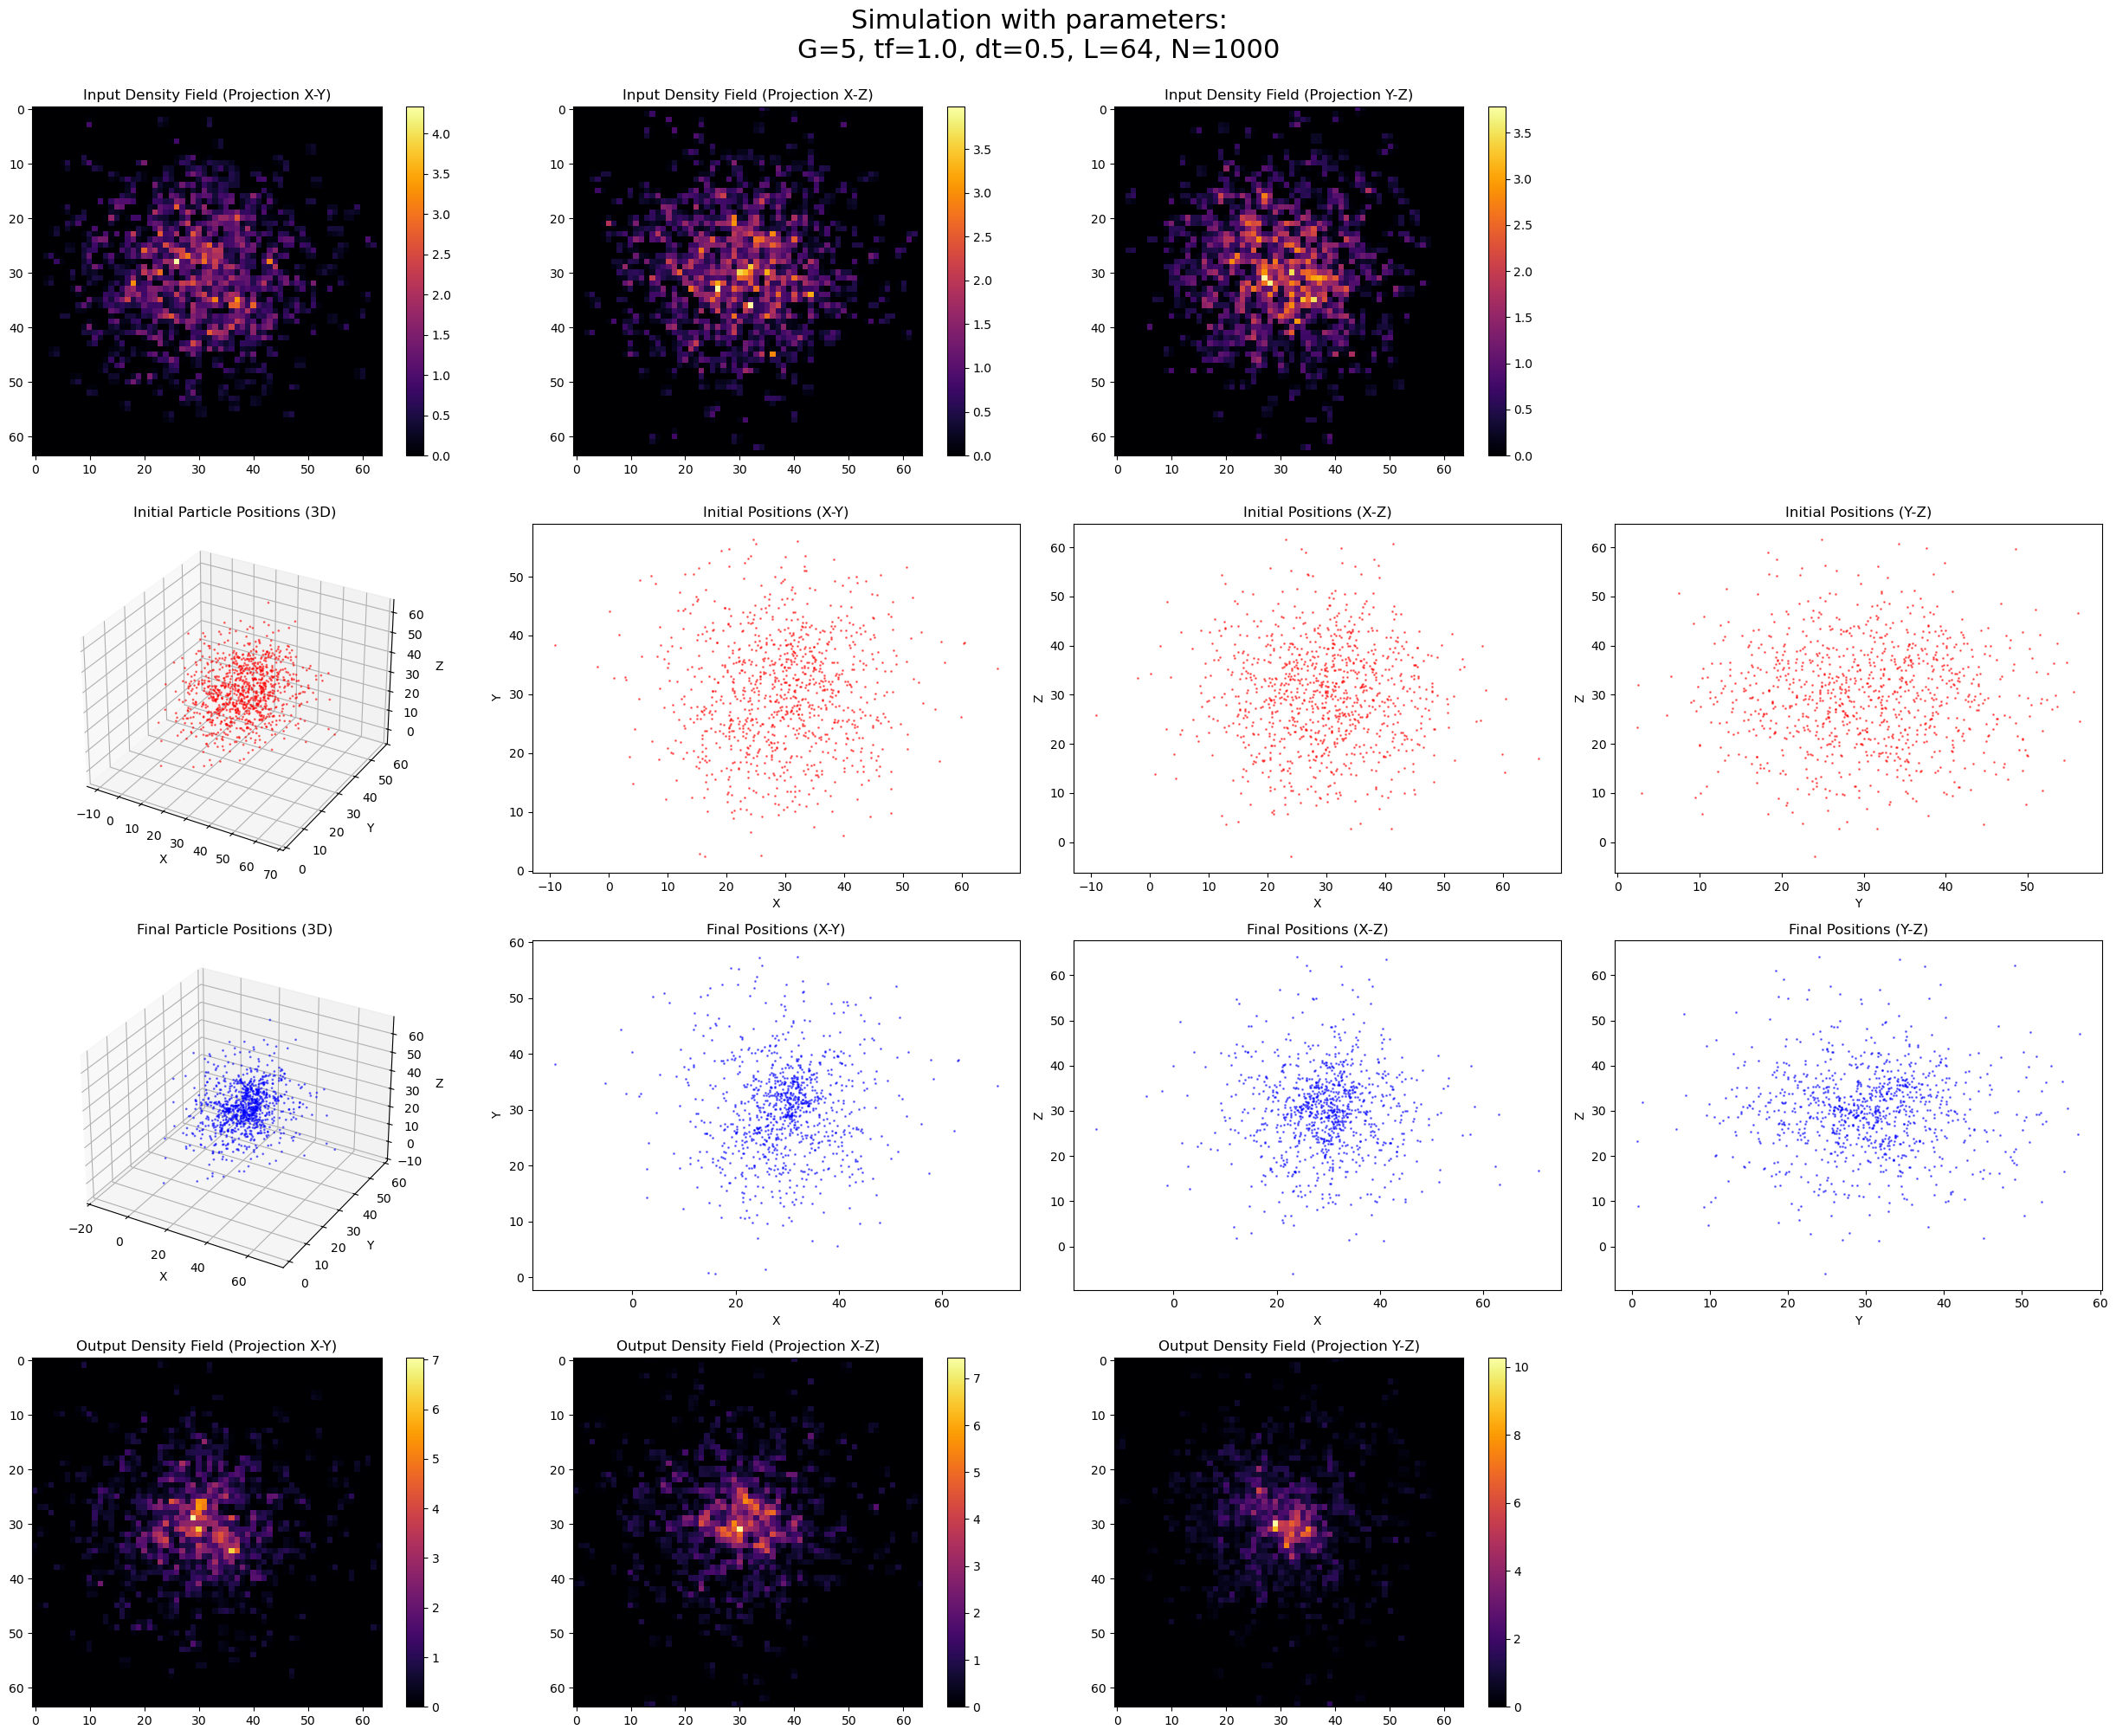

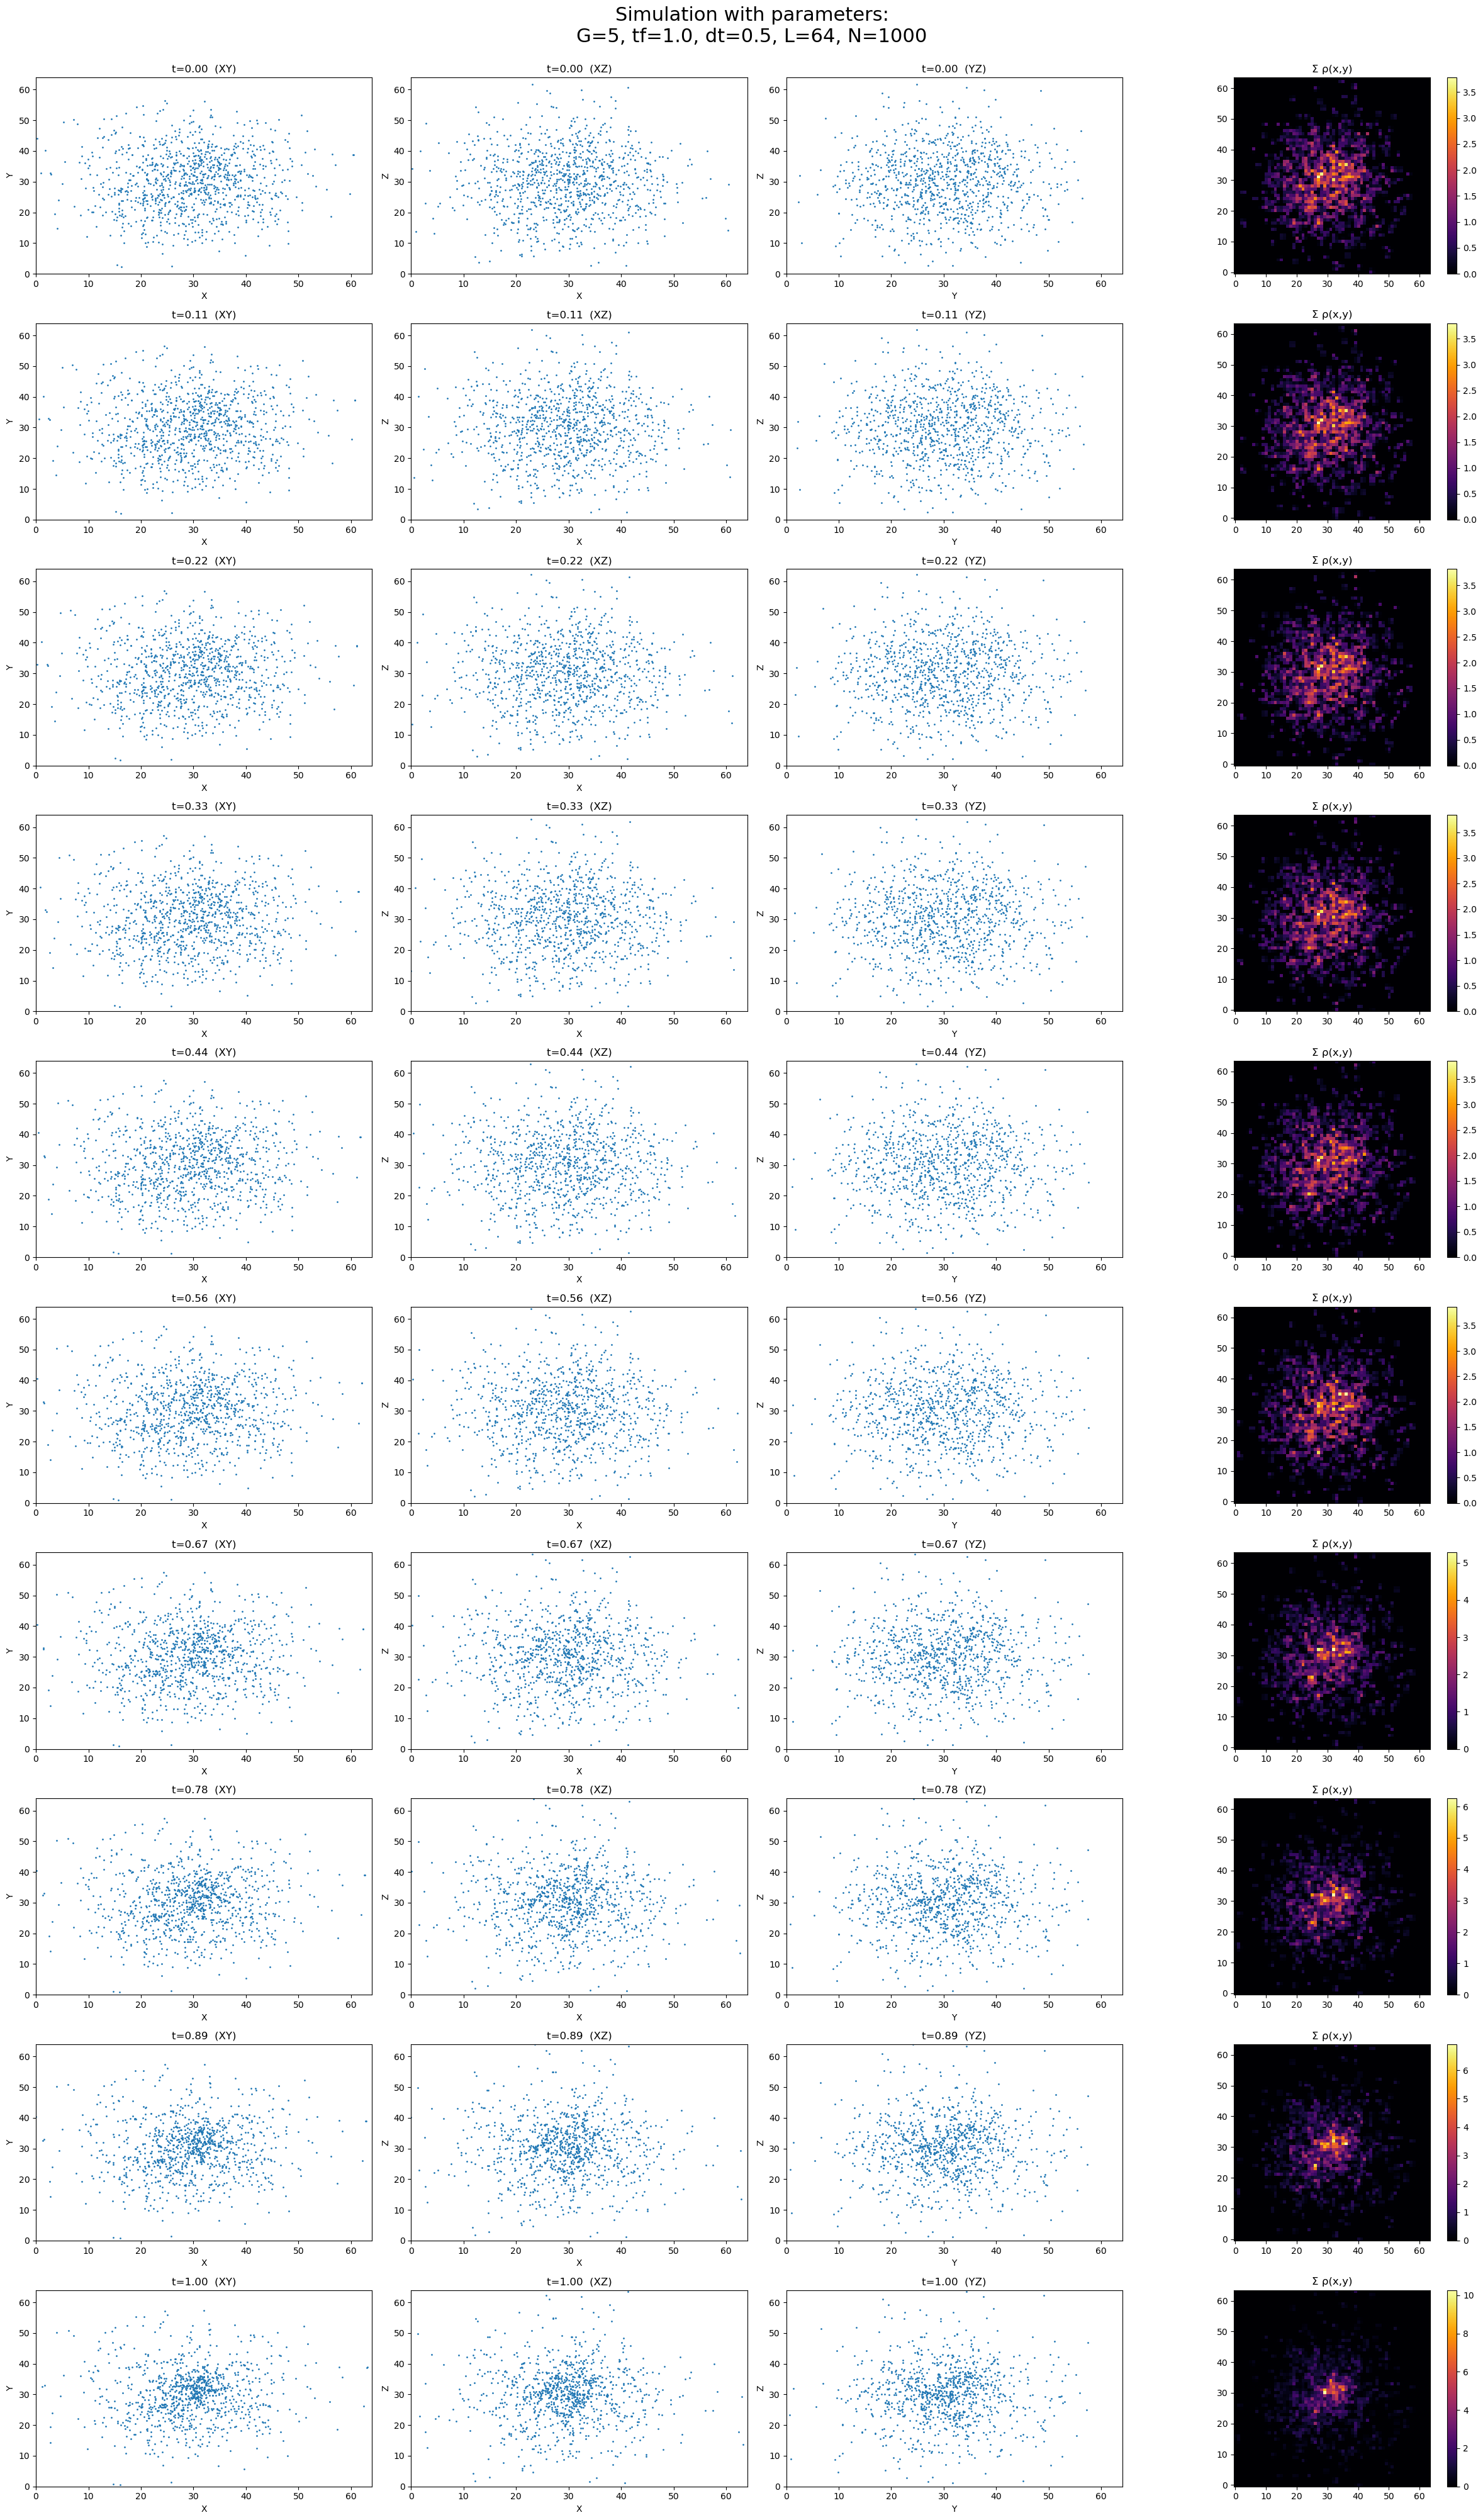

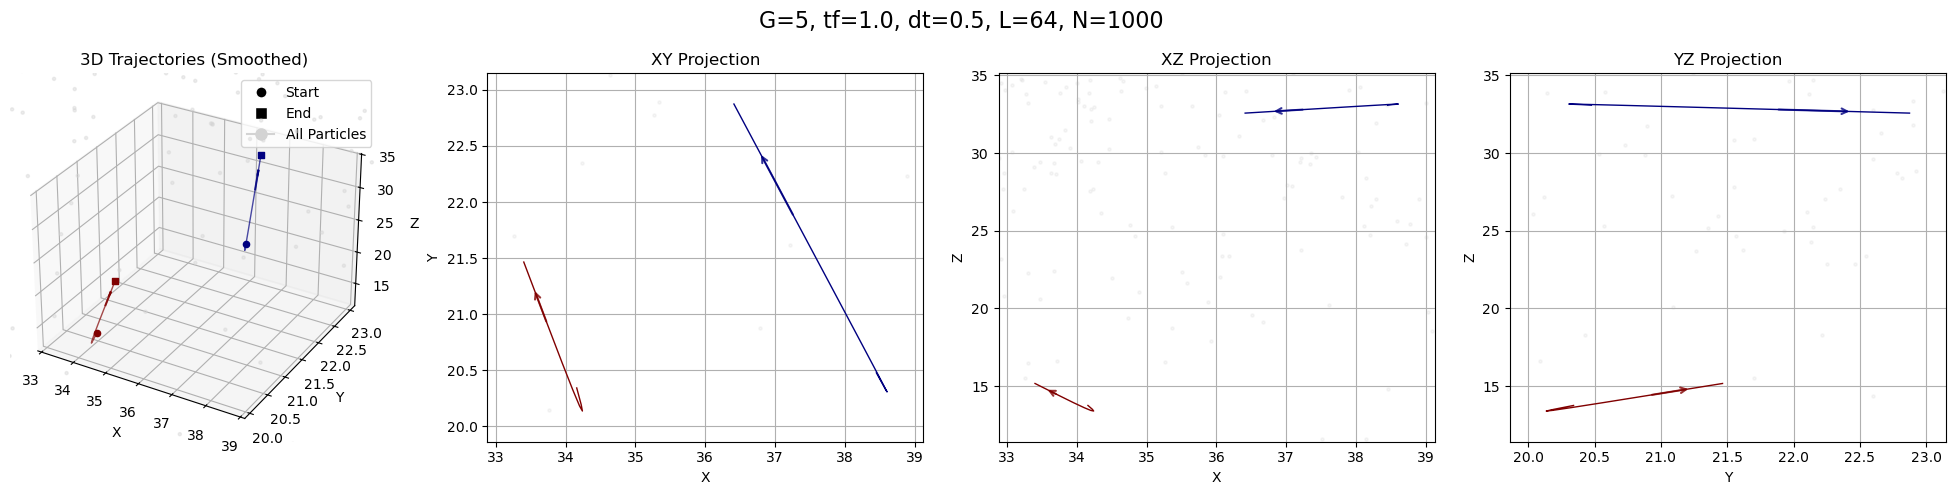

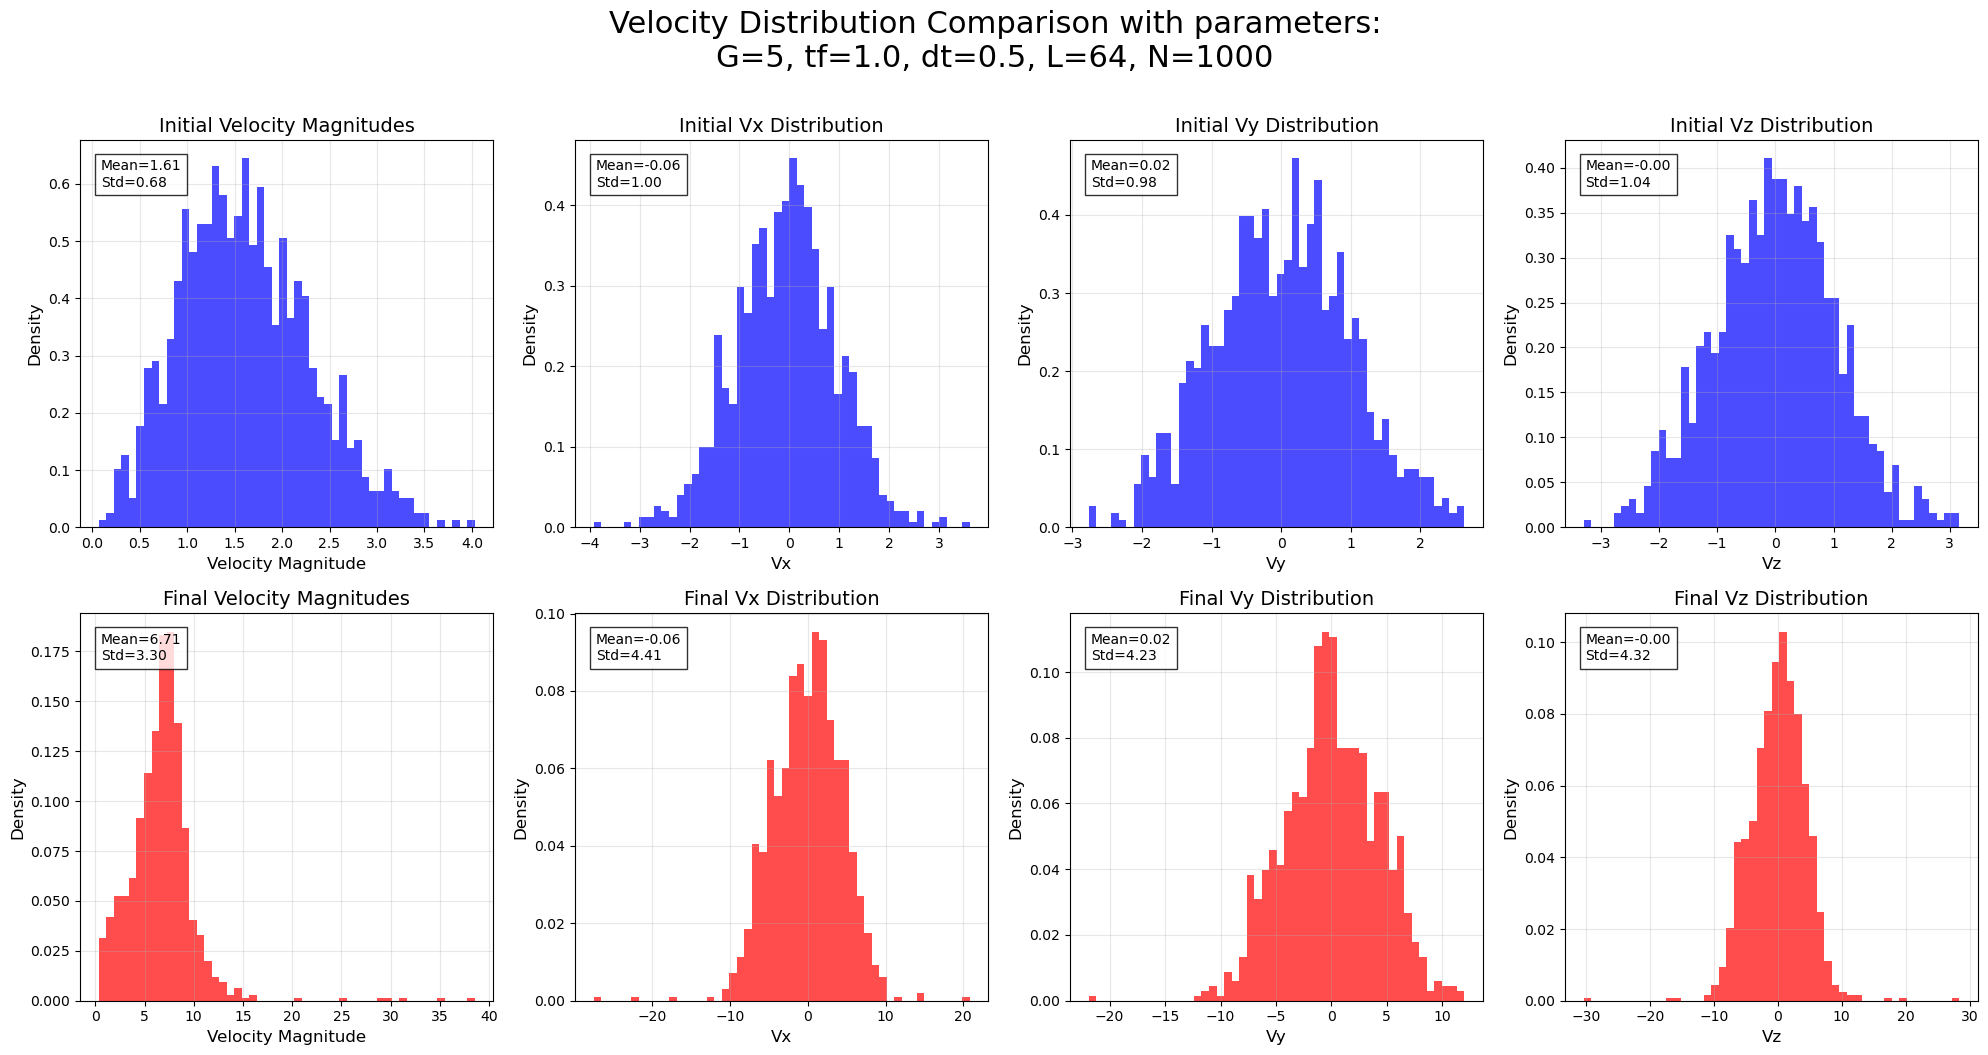

In [15]:
# Plotting
fig = plot_density_fields_and_positions(G, t_f, dt, length, n_part, input_field, init_pos, final_pos, output_field)
fig_steps, axes_steps = plot_all_timesteps(sol, length, G, t_f, dt, n_part, skip=skip)
particle_indices = np.random.choice(n_part, 2, replace=False)
fig_trajectories = plot_trajectories(sol, G, t_f, dt, length, n_part, particle_indices=particle_indices)
fig_velocity = plot_velocity_distributions(sol, G, t_f, dt, length, n_part)

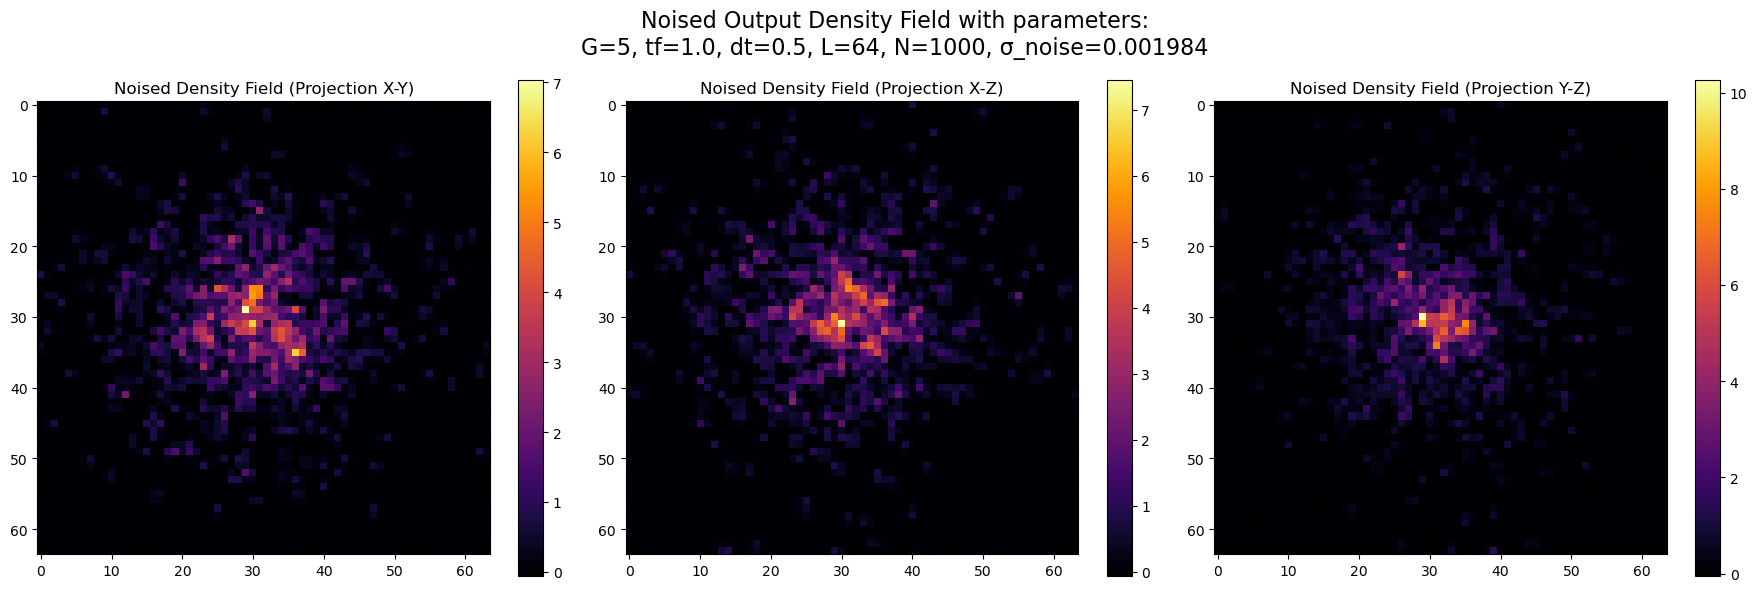

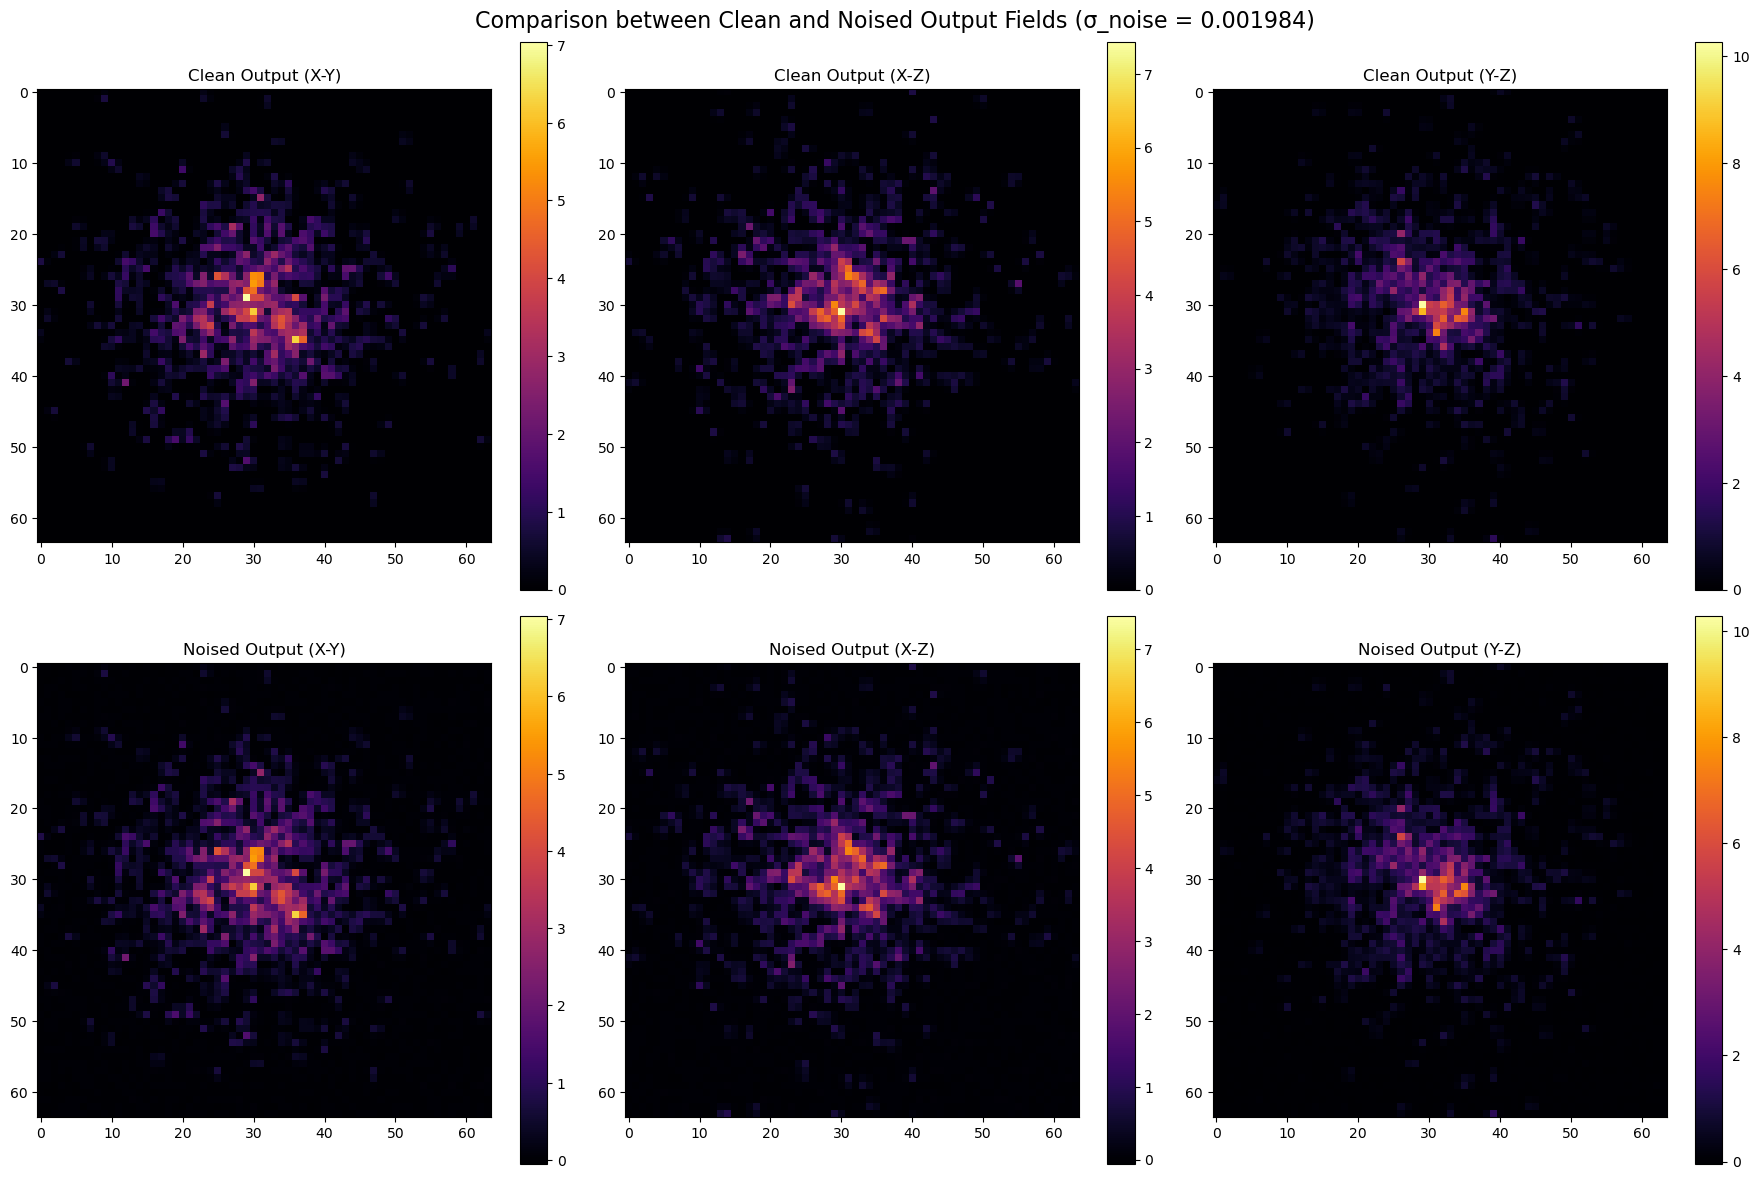

In [16]:
# Create a figure to visualize the noised output field (data)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Title with simulation parameters
title = 'Noised Output Density Field with parameters:'
param_info = f'G={G}, tf={t_f}, dt={dt}, L={length}, N={n_part}, σ_noise={sigma_n_true:.6f}'
fig.suptitle(title + '\n' + param_info, fontsize=16)

# Plot the 3 projections of the data field
im1 = axes[0].imshow(jnp.sum(data, axis=0), cmap='inferno')
axes[0].set_title('Noised Density Field (Projection X-Y)')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(jnp.sum(data, axis=1), cmap='inferno')
axes[1].set_title('Noised Density Field (Projection X-Z)')
fig.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(jnp.sum(data, axis=2), cmap='inferno')
axes[2].set_title('Noised Density Field (Projection Y-Z)')
fig.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

# Create a comparison figure between clean and noised output
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Clean field (top row)
im1 = axes[0, 0].imshow(jnp.sum(output_field, axis=0), cmap='inferno')
axes[0, 0].set_title('Clean Output (X-Y)')
fig.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(jnp.sum(output_field, axis=1), cmap='inferno')
axes[0, 1].set_title('Clean Output (X-Z)')
fig.colorbar(im2, ax=axes[0, 1])

im3 = axes[0, 2].imshow(jnp.sum(output_field, axis=2), cmap='inferno')
axes[0, 2].set_title('Clean Output (Y-Z)')
fig.colorbar(im3, ax=axes[0, 2])

# Noised field (bottom row)
im4 = axes[1, 0].imshow(jnp.sum(data, axis=0), cmap='inferno')
axes[1, 0].set_title('Noised Output (X-Y)')
fig.colorbar(im4, ax=axes[1, 0])

im5 = axes[1, 1].imshow(jnp.sum(data, axis=1), cmap='inferno')
axes[1, 1].set_title('Noised Output (X-Z)')
fig.colorbar(im5, ax=axes[1, 1])

im6 = axes[1, 2].imshow(jnp.sum(data, axis=2), cmap='inferno')
axes[1, 2].set_title('Noised Output (Y-Z)')
fig.colorbar(im6, ax=axes[1, 2])

# Add a title showing the noise standard deviation
fig.suptitle(f'Comparison between Clean and Noised Output Fields (σ_noise = {sigma_n_true:.6f})', fontsize=16)

plt.tight_layout()
plt.show()

Complete forward model

In [18]:
master_key = random.PRNGKey(123456) 

pos_key, vel_key = random.split(master_key, 2)
keys = jnp.array([pos_key, vel_key])


def gaussian_model(parameters,n_part = 1000, keys=keys, grid_shape=(64, 64, 64)):
    sigma,mean,vel_sigma = parameters
    init_pos = jax.random.normal(keys[0], (n_part, 3))*sigma + mean
    init_vel = jax.random.normal(keys[1], (n_part, 3))*vel_sigma
    y0 = jnp.stack([init_pos, init_vel],axis=0)
    sol = diffeqsolve(term, solver, t0=0.0, t1=t_f, dt0=dt, y0=y0, saveat=SaveAt(ts=ts))
    final_pos = sol.ys[-1, 0] 
    output_field = cic_paint(jnp.zeros(grid_shape), final_pos)
    return output_field

## HMC Sampling 

In [19]:
import jax.scipy.stats as stats
import corner
import blackjax

In [20]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [21]:
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

### Test of BlackJax HMC for Gaussian sampling

In [14]:
loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)

def logdensity_fn(loc, log_scale, observed=observed):
    """Univariate Normal"""
    scale = jnp.exp(log_scale)
    logjac = log_scale
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return logjac + jnp.sum(logpdf)


logdensity = lambda x: logdensity_fn(**x)

In [15]:
inv_mass_matrix = np.array([0.5, 0.01])
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)

In [16]:
initial_position = {"loc": 1.0, "log_scale": 1.0}
initial_state = hmc.init(initial_position)
initial_state

HMCState(position={'loc': 1.0, 'log_scale': 1.0}, logdensity=Array(-34454.13, dtype=float32), logdensity_grad={'loc': Array(1211.0535, dtype=float32, weak_type=True), 'log_scale': Array(64073.387, dtype=float32, weak_type=True)})

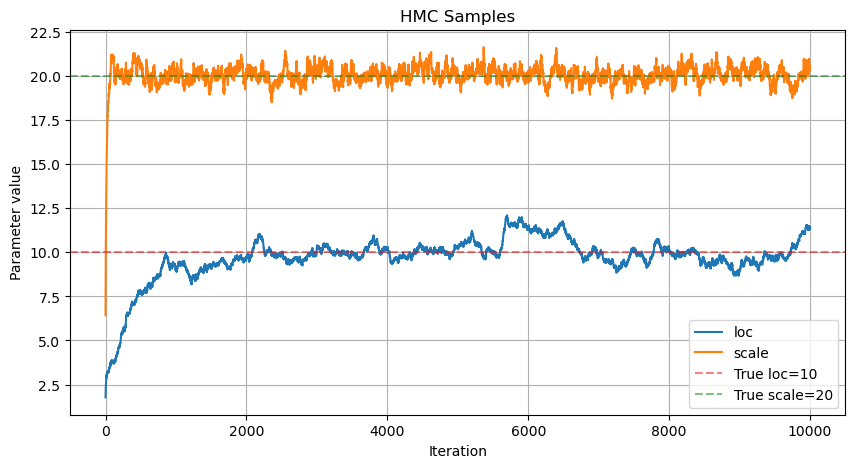

In [17]:
hmc_kernel = jax.jit(hmc.step)
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, hmc_kernel, initial_state, 10_000)

mcmc_samples = states.position
mcmc_samples["scale"] = jnp.exp(mcmc_samples["log_scale"]).block_until_ready()

# Plotting the HMC samples
plt.figure(figsize=(10, 5))
plt.plot(mcmc_samples["loc"], label="loc")
plt.plot(mcmc_samples["scale"], label="scale")
plt.axhline(y=loc, color='r', linestyle='--', alpha=0.5, label=f'True loc={loc}')
plt.axhline(y=scale, color='g', linestyle='--', alpha=0.5, label=f'True scale={scale}')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.title('HMC Samples')
plt.legend()
plt.grid(True)
plt.show()


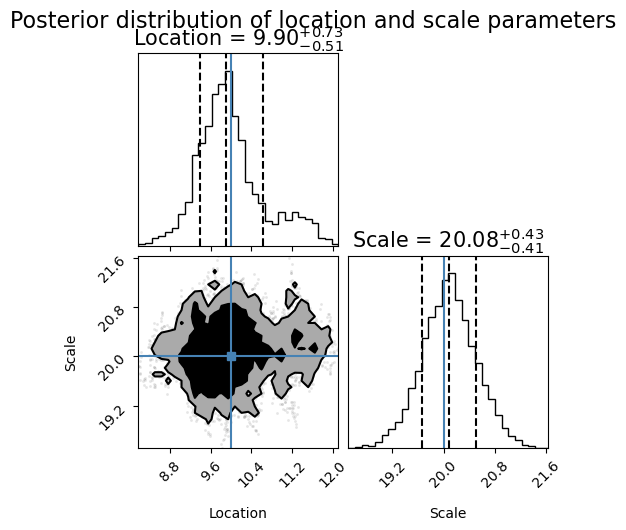

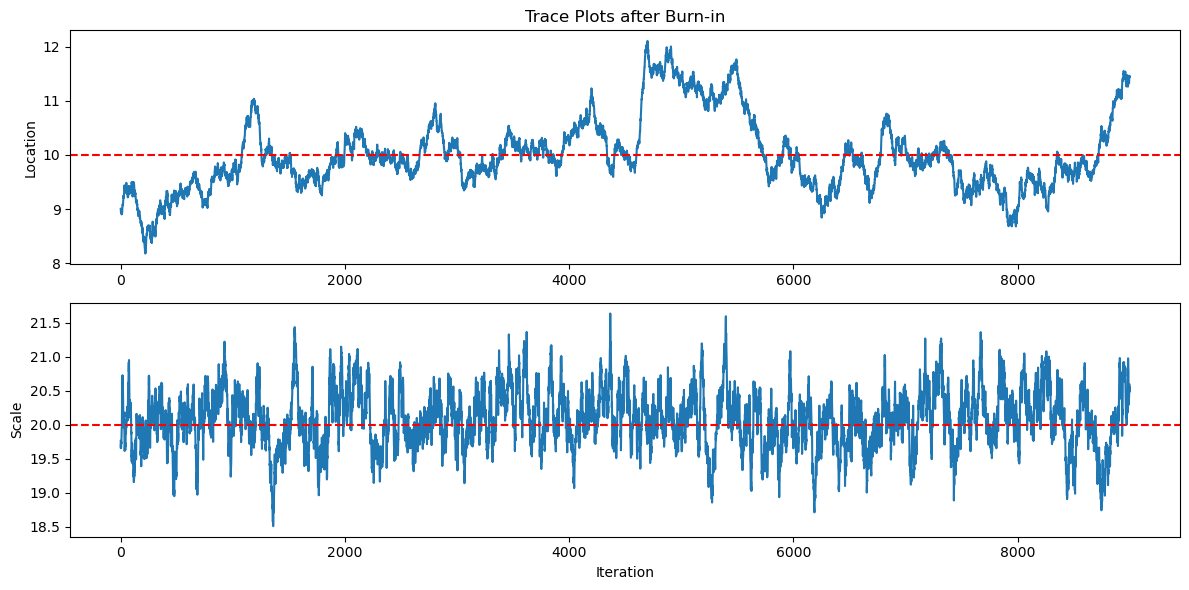

In [18]:
# Convert the samples from the dictionary to a numpy array for corner plot
samples = np.column_stack([
    mcmc_samples["loc"], 
    mcmc_samples["scale"]
])

# Apply burn-in by discarding the first 1000 samples
burnin = 1000
samples = samples[burnin:]

# Create the corner plot
fig = corner.corner(
    samples, 
    labels=["Location", "Scale"],
    truths=[loc, scale],  # True parameter values
    show_titles=True, 
    title_kwargs={"fontsize": 15},
    quantiles=[0.16, 0.5, 0.84],  # Show 68% intervals
    levels=(0.68, 0.95),  # 1-sigma and 2-sigma contours
    plot_contours=True,
    fill_contours=True,
    bins=30
)

# Add a title to the figure
fig.suptitle("Posterior distribution of location and scale parameters", fontsize=16)
plt.subplots_adjust(top=0.90)  # Make room for the title

# Display the corner plot
plt.show()

# Also create a trace plot to check convergence
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(mcmc_samples["loc"][burnin:])
plt.axhline(y=loc, color='r', linestyle='--')
plt.ylabel('Location')
plt.title('Trace Plots after Burn-in')

plt.subplot(2, 1, 2)
plt.plot(mcmc_samples["scale"][burnin:])
plt.axhline(y=scale, color='r', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Scale')

plt.tight_layout()
plt.show()

### Sampling of posterior of our gaussian model for particules initial state

### Log-likelihood 1

The likelihood function $ \mathcal{L}_1 $ can be expressed as:

$$
\mathcal{L}_1(\theta) = - \sum_{i} \left( \text{model}(\theta)_i - \text{data}_i \right)^2
$$

where:
- $ \theta $ represents the parameters of the model,
- $ \text{model}(\theta) $ is the output of the Gaussian model given the parameters $ \theta $,
- $ \text{data} $ is the observed data,
- The summation is over all data points $ i $.


In [22]:
def log_likelihood_1(parameters): 
    out = gaussian_model(parameters)
    return - jnp.sum((out-data)**2) 

jvag = jax.value_and_grad(log_likelihood_1)

In [23]:
# Define log density function for posterior sampling of gaussian_model parameters
def log_posterior_1(params_dict):
    """Log posterior density for the gaussian model parameters."""
    # Extract parameters from dictionary
    sigma = params_dict['sigma']
    mean = params_dict['mean'] 
    vel_sigma = params_dict['vel_sigma']
    
    # Prior distributions - using weakly informative priors
    log_prior = 0.0
    log_prior += stats.norm.logpdf(sigma, 10.0, 0.5)       # Prior for sigma
    log_prior += stats.norm.logpdf(mean, 30.0, 0.5)       # Prior for mean
    log_prior += stats.norm.logpdf(vel_sigma, 1.0, 0.1)    # Prior for vel_sigma
    
    # Convert parameters to array for likelihood calculation
    params = jnp.array([sigma, mean, vel_sigma])
    
    # Calculate negative log likelihood (negate because HMC maximizes)
    log_likelihood = log_likelihood_1(params)
    
    # Return log posterior (prior - negative log likelihood)
    return log_prior + log_likelihood

In [24]:
# Configure HMC sampler with appropriate scaling for parameters
inv_mass_matrix = jnp.array([0.1, 0.5, 0.1])  # Tuned for parameter scales
step_size = 1e-3  # Small step size for stable sampling
num_integration_steps = 50  # More steps for complex posterior

# Initialize HMC
hmc = blackjax.hmc(log_posterior_1, step_size, inv_mass_matrix, num_integration_steps)
hmc_kernel = jax.jit(hmc.step)

# Initial position (starting from known good values)
initial_position = {"sigma": 10.0, "mean": 30.0, "vel_sigma": 1.0}
initial_state = hmc.init(initial_position)

# Run HMC sampling
num_samples = 5000
rng_key, sample_key = jax.random.split(rng_key)  # Using the existing key
states = inference_loop(sample_key, hmc_kernel, initial_state, num_samples)

# Extract samples
mcmc_samples = states.position

KeyboardInterrupt: 

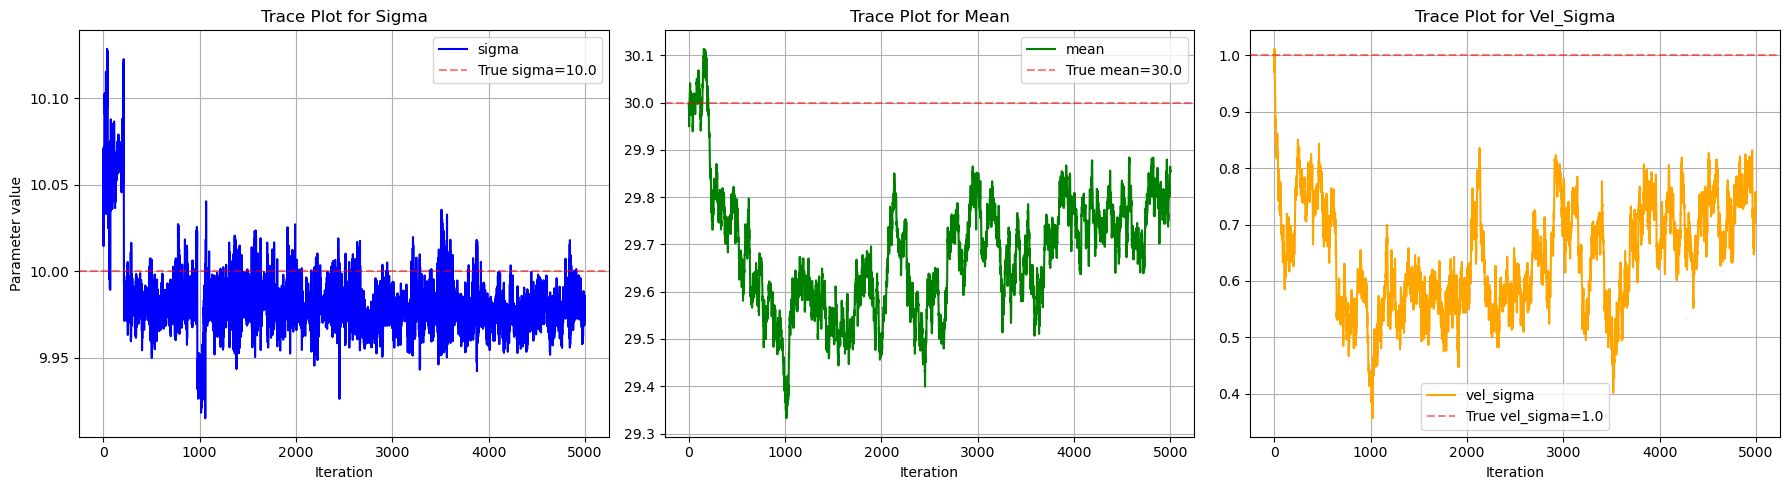

KeyError: 0

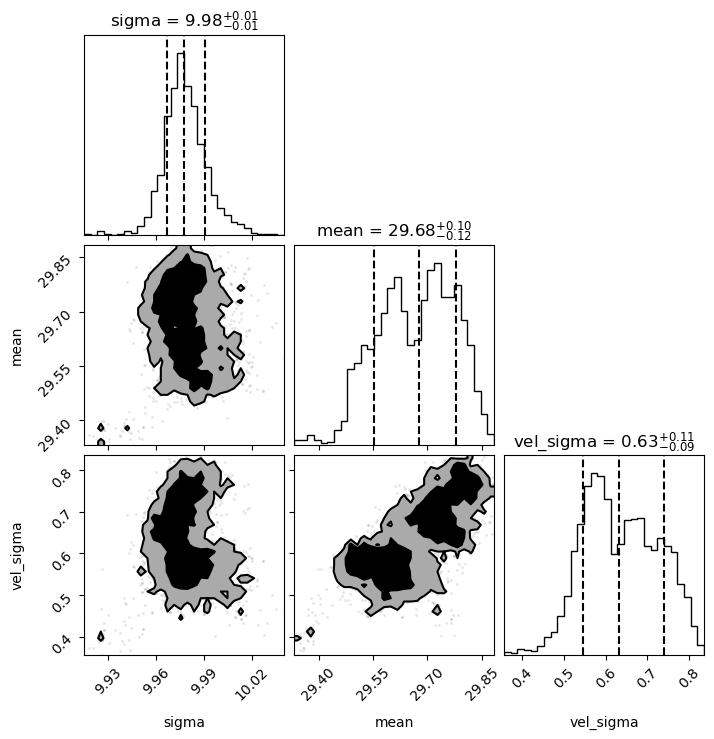

In [22]:
# Create trace plots with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

title = 'Sampling of Gaussian Model Parameters distribution with HMC'
param_info = f'G={G}, tf={t_f}, dt={dt}, L={length}, N={n_part}'

# Plot sigma
axes[0].plot(mcmc_samples["sigma"], label="sigma", color='blue')
axes[0].axhline(y=theta["pos_std"], color='r', linestyle='--', alpha=0.5, label=f'True sigma={theta["pos_std"]}')
axes[0].set_title('Sampling of Sigma')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Parameter value')
axes[0].legend()
axes[0].grid(True)

# Plot mean
axes[1].plot(mcmc_samples["mean"], label="mean", color='green')
axes[1].axhline(y=theta["pos_mean"], color='r', linestyle='--', alpha=0.5, label=f'True mean={theta["pos_mean"]}')
axes[1].set_title('Sampling of Mean')
axes[1].set_xlabel('Iteration')
axes[1].legend()
axes[1].grid(True)

# Plot vel_sigma
axes[2].plot(mcmc_samples["vel_sigma"], label="vel_sigma", color='orange')
axes[2].axhline(y=theta["vel_std"], color='r', linestyle='--', alpha=0.5, label=f'True vel_sigma={theta["vel_std"]}')
axes[2].set_title('Sampling of Vel_Sigma')
axes[2].set_xlabel('Iteration')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Create corner plot after burn-in
burnin = 1000
samples = np.column_stack([
    np.array(mcmc_samples["sigma"])[burnin:],
    np.array(mcmc_samples["mean"])[burnin:],
    np.array(mcmc_samples["vel_sigma"])[burnin:]
])

fig = corner.corner(
    samples, 
    labels=["sigma", "mean", "vel_sigma"],
    truths=theta,  # True parameter values
    show_titles=True, 
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],  # Show 68% intervals
    levels=(0.68, 0.95),  # 1-sigma and 2-sigma contours
    plot_contours=True,
    fill_contours=True,
    bins=30
)

fig.suptitle("Posterior distribution of gaussian model parameters", fontsize=16)
plt.subplots_adjust(top=0.90)
plt.show()

### Log-likelihood 2

In [33]:
def log_likelihood_2(parameters, noise=0.1):
    out = gaussian_model(parameters)
    residuals = out - data
    chi2  = jnp.sum(residuals ** 2) / noise**2
    norm  = data.size * jnp.log(noise)
    return -0.5 * chi2 - norm

In [34]:
def log_posterior_2(params_dict):
    sigma = params_dict['sigma']
    mean = params_dict['mean'] 
    vel_sigma = params_dict['vel_sigma']
    
    log_prior = 0.0
    log_prior += stats.norm.logpdf(sigma, 10.0, 5.0)       # Prior for sigma
    log_prior += stats.norm.logpdf(mean, 30.0, 10.0)       # Prior for mean
    log_prior += stats.norm.logpdf(vel_sigma, 1.0, 0.5)    # Prior for vel_sigma
    
    params = jnp.array([sigma, mean, vel_sigma])
    
    log_likelihood = log_likelihood_2(params) 
    
    return log_prior + log_likelihood

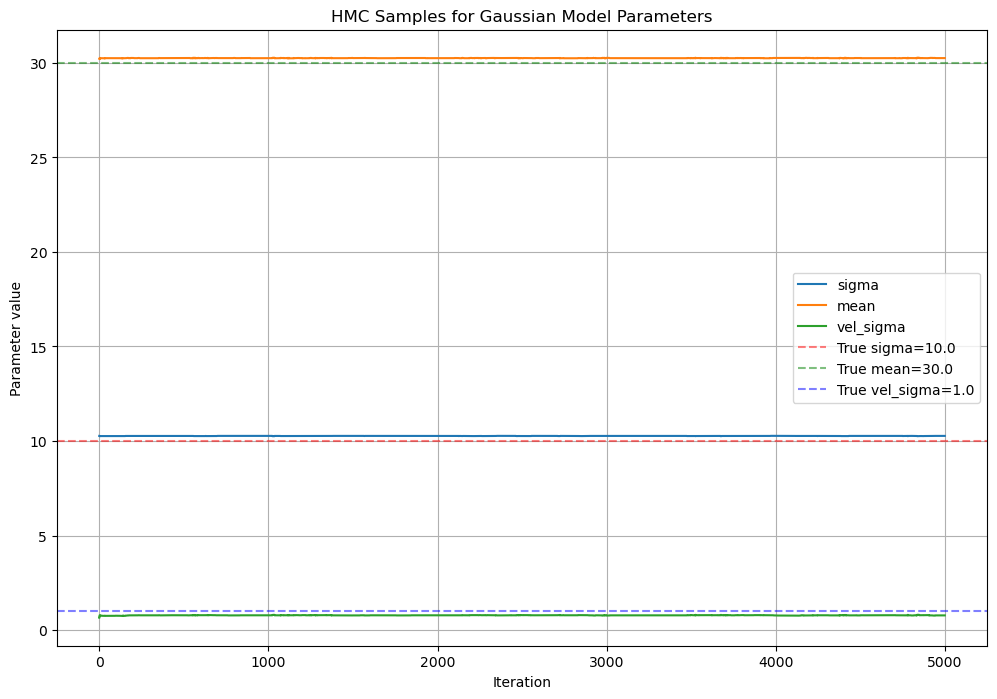

In [35]:
# Configure HMC sampler with appropriate scaling for parameters
inv_mass_matrix = jnp.array([0.1, 0.5, 0.1])  # Tuned for parameter scales
step_size = 1e-3  # Small step size for stable sampling
num_integration_steps = 50  # More steps for complex posterior

# Initialize HMC
hmc = blackjax.hmc(log_posterior_2, step_size, inv_mass_matrix, num_integration_steps)
hmc_kernel = jax.jit(hmc.step)

# Initial position (starting from known good values)
initial_position = {"sigma": 10.0, "mean": 30.0, "vel_sigma": 1.0}
initial_state = hmc.init(initial_position)

# Run HMC sampling
num_samples = 5000
rng_key, sample_key = jax.random.split(rng_key)  # Using the existing key
states = inference_loop(sample_key, hmc_kernel, initial_state, num_samples)

# Extract samples
mcmc_samples = states.position

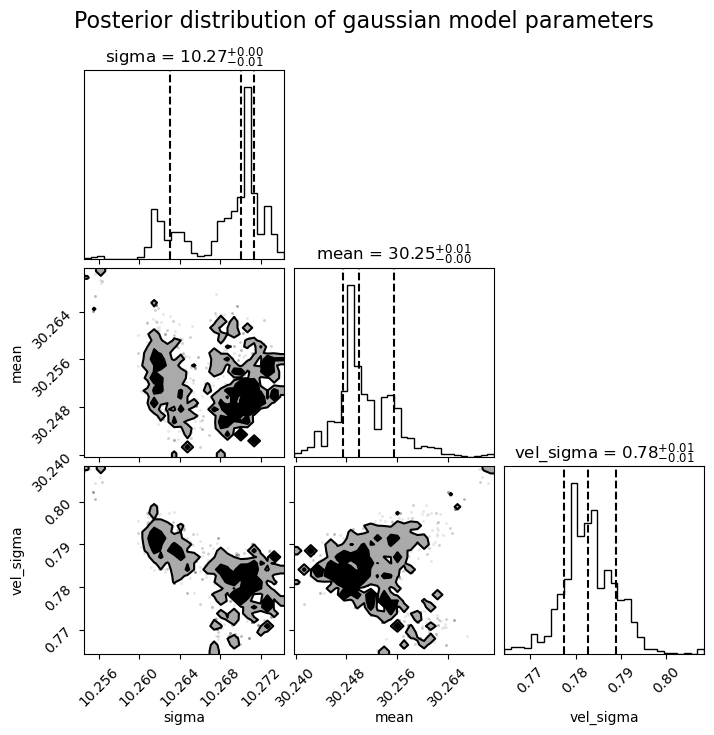

In [36]:
# Create trace plots
plt.figure(figsize=(12, 8))
plt.plot(mcmc_samples["sigma"], label="sigma")
plt.plot(mcmc_samples["mean"], label="mean")
plt.plot(mcmc_samples["vel_sigma"], label="vel_sigma")
plt.axhline(y=theta[0], color='r', linestyle='--', alpha=0.5, label=f'True sigma={theta[0]}')
plt.axhline(y=theta[1], color='g', linestyle='--', alpha=0.5, label=f'True mean={theta[1]}')
plt.axhline(y=theta[2], color='b', linestyle='--', alpha=0.5, label=f'True vel_sigma={theta[2]}')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.title('HMC Samples for Gaussian Model Parameters')
plt.legend()
plt.grid(True)
plt.show()

# Create corner plot after burn-in
burnin = 1000
samples = np.column_stack([
    np.array(mcmc_samples["sigma"])[burnin:],
    np.array(mcmc_samples["mean"])[burnin:],
    np.array(mcmc_samples["vel_sigma"])[burnin:]
])

fig = corner.corner(
    samples, 
    labels=["sigma", "mean", "vel_sigma"],
    truths=theta,  # True parameter values
    show_titles=True, 
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],  # Show 68% intervals
    levels=(0.68, 0.95),  # 1-sigma and 2-sigma contours
    plot_contours=True,
    fill_contours=True,
    bins=30
)

fig.suptitle("Posterior distribution of gaussian model parameters", fontsize=16)
plt.subplots_adjust(top=0.90)
plt.show()

### NUTS with Stan Window adaptation

#### Log-likelihood 1 with NUTS

In [37]:
warmup = blackjax.window_adaptation(blackjax.nuts, log_posterior_1)
initial_position = {"sigma": 10.0, "mean": 30.0, "vel_sigma": 1.0}
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=1000)

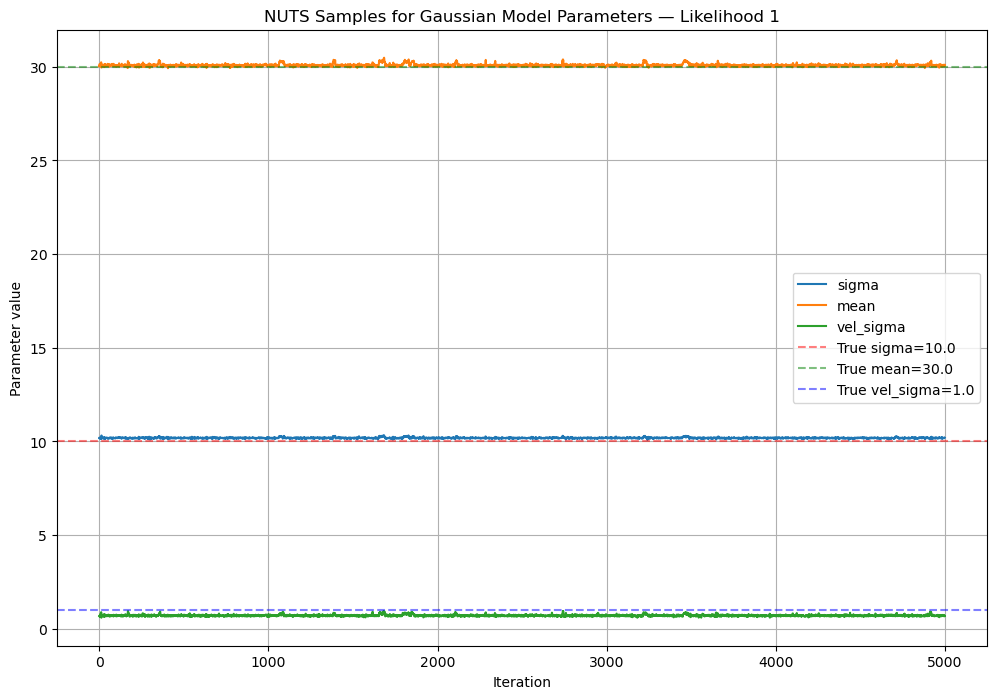

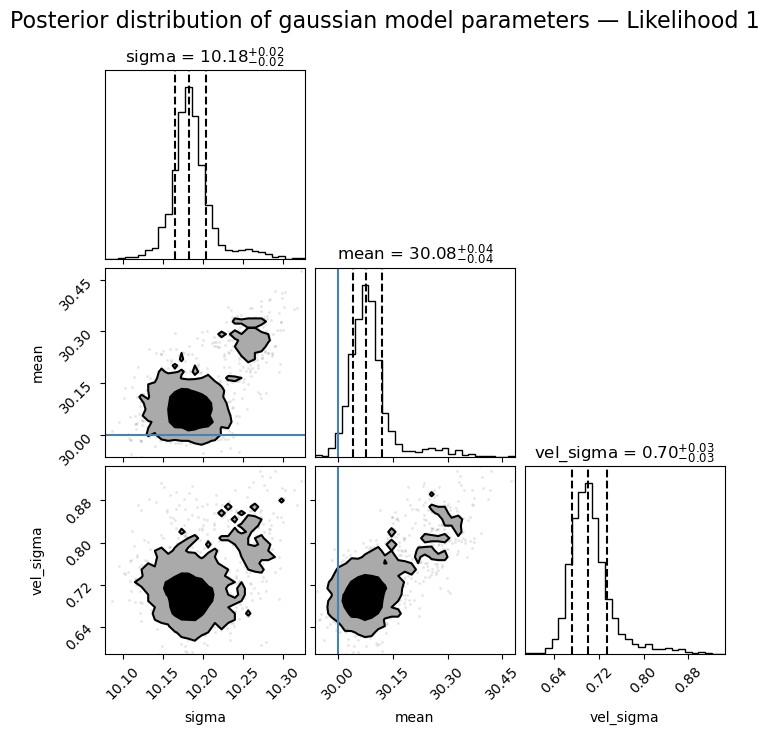

In [38]:
kernel = blackjax.nuts(log_posterior_1, **parameters).step
num_samples = 5000
states = inference_loop(sample_key, kernel, state, num_samples)

mcmc_samples = states.position

In [ ]:
# Create trace plots
plt.figure(figsize=(12, 8))
plt.plot(mcmc_samples["sigma"], label="sigma")
plt.plot(mcmc_samples["mean"], label="mean")
plt.plot(mcmc_samples["vel_sigma"], label="vel_sigma")
plt.axhline(y=theta[0], color='r', linestyle='--', alpha=0.5, label=f'True sigma={theta[0]}')
plt.axhline(y=theta[1], color='g', linestyle='--', alpha=0.5, label=f'True mean={theta[1]}')
plt.axhline(y=theta[2], color='b', linestyle='--', alpha=0.5, label=f'True vel_sigma={theta[2]}')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.title('NUTS Samples for Gaussian Model Parameters — Likelihood 1')
plt.legend()
plt.grid(True)
plt.show()

burnin = 1000
samples = np.column_stack([
    np.array(mcmc_samples["sigma"])[burnin:],
    np.array(mcmc_samples["mean"])[burnin:],
    np.array(mcmc_samples["vel_sigma"])[burnin:]
])

fig = corner.corner(
    samples, 
    labels=["sigma", "mean", "vel_sigma"],
    truths=theta,  # True parameter values
    show_titles=True, 
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],  # Show 68% intervals
    levels=(0.68, 0.95),  # 1-sigma and 2-sigma contours
    plot_contours=True,
    fill_contours=True,
    bins=30
)

fig.suptitle("Posterior distribution of gaussian model parameters — Likelihood 1", fontsize=16)
plt.subplots_adjust(top=0.90)
plt.show()

#### Log-likelihood 2 with NUTS

In [25]:
warmup = blackjax.window_adaptation(blackjax.nuts, log_posterior_2)
initial_position = {"sigma": 10.0, "mean": 30.0, "vel_sigma": 1.0}
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=1000)

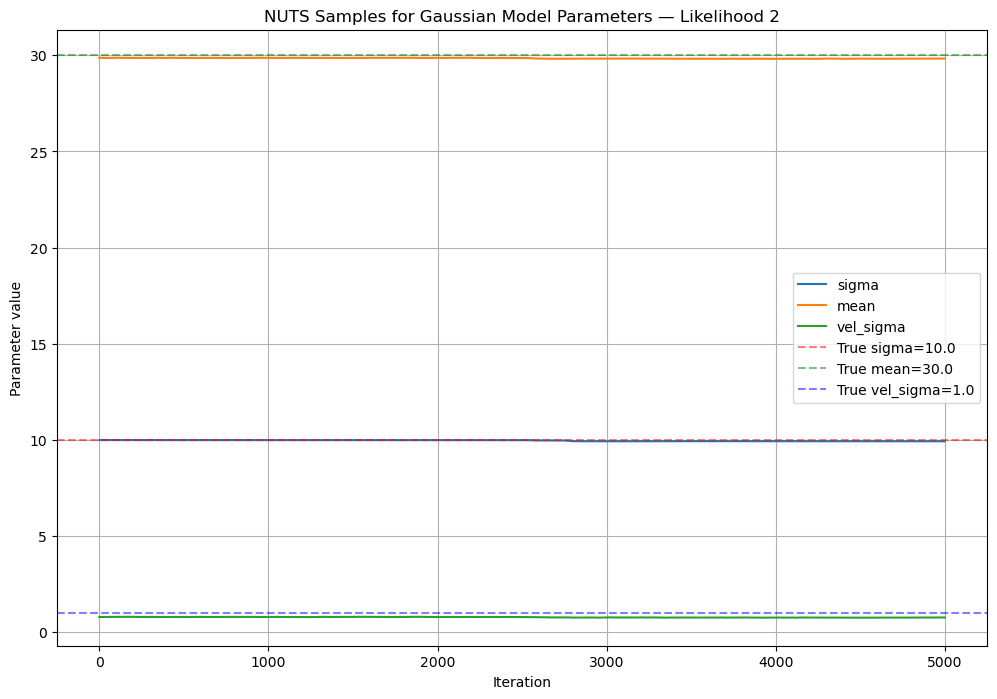

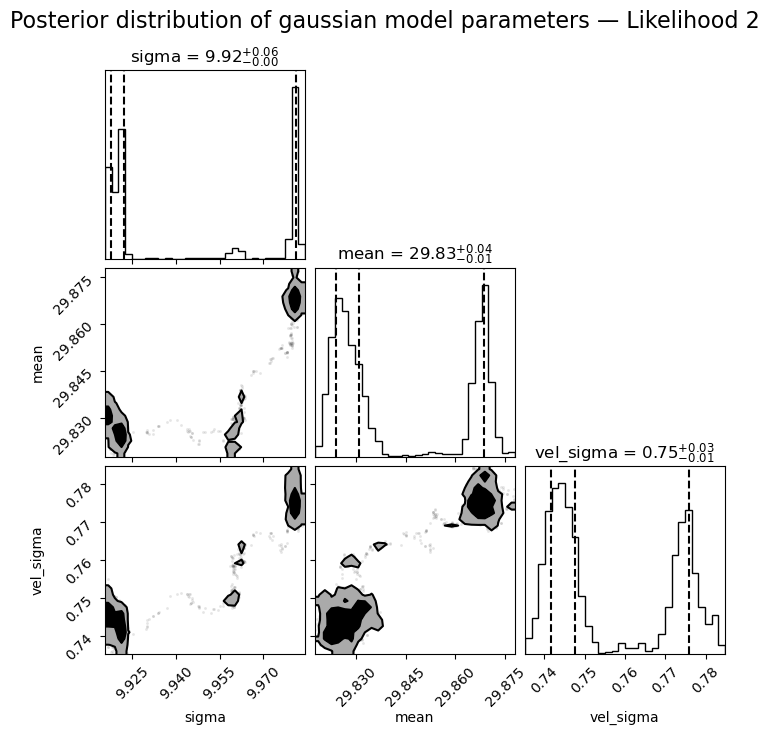

In [26]:
kernel = blackjax.nuts(log_posterior_2, **parameters).step
num_samples = 5000
states = inference_loop(sample_key, kernel, state, num_samples)

mcmc_samples = states.position

In [ ]:
# Create trace plots
plt.figure(figsize=(12, 8))
plt.plot(mcmc_samples["sigma"], label="sigma")
plt.plot(mcmc_samples["mean"], label="mean")
plt.plot(mcmc_samples["vel_sigma"], label="vel_sigma")
plt.axhline(y=theta[0], color='r', linestyle='--', alpha=0.5, label=f'True sigma={theta[0]}')
plt.axhline(y=theta[1], color='g', linestyle='--', alpha=0.5, label=f'True mean={theta[1]}')
plt.axhline(y=theta[2], color='b', linestyle='--', alpha=0.5, label=f'True vel_sigma={theta[2]}')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.title('NUTS Samples for Gaussian Model Parameters — Likelihood 2')
plt.legend()
plt.grid(True)
plt.show()

burnin = 1000
samples = np.column_stack([
    np.array(mcmc_samples["sigma"])[burnin:],
    np.array(mcmc_samples["mean"])[burnin:],
    np.array(mcmc_samples["vel_sigma"])[burnin:]
])

fig = corner.corner(
    samples, 
    labels=["sigma", "mean", "vel_sigma"],
    truths=theta,  # True parameter values
    show_titles=True, 
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],  # Show 68% intervals
    levels=(0.68, 0.95),  # 1-sigma and 2-sigma contours
    plot_contours=True,
    fill_contours=True,
    bins=30
)

fig.suptitle("Posterior distribution of gaussian model parameters — Likelihood 2", fontsize=16)
plt.subplots_adjust(top=0.90)
plt.show()

### Likelihood 3

In [21]:
def log_likelihood_3(parameters, variance=1.0, n_realizations=10):
    """
    Proper log likelihood function assuming Gaussian noise with constant variance.
    
    Args:
        parameters: Model parameters [sigma, mean, vel_sigma]
        variance: Assumed noise variance (controls posterior concentration)
        n_realizations: Number of model realizations to average over
    
    Returns:
        log likelihood value
    """
    total_ll = 0
    n_points = jnp.size(data)  # Total number of data points
    
    # Constant normalization term
    log_norm = -0.5 * n_points * np.log(2 * np.pi * variance)
    
    for i in range(n_realizations):
        key = jax.random.PRNGKey(i)
        model_output = gaussian_model(parameters, key=key)
        
        # Calculate squared errors
        sq_errors = jnp.sum((model_output - data)**2)
        
        # Full log likelihood for this realization
        realization_ll = -0.5 * sq_errors / variance + log_norm
        total_ll += realization_ll
        
    # Return average log likelihood across realizations
    return total_ll / n_realizations

def log_posterior_3(params_dict):
    """Log posterior density for the gaussian model parameters."""
    # Extract parameters from dictionary
    sigma = params_dict['sigma']
    mean = params_dict['mean'] 
    vel_sigma = params_dict['vel_sigma']
    
    # Prior distributions - using weakly informative priors
    log_prior = 0.0
    log_prior += stats.norm.logpdf(sigma, 10.0, 5.0)       # Prior for sigma
    log_prior += stats.norm.logpdf(mean, 30.0, 10.0)       # Prior for mean
    log_prior += stats.norm.logpdf(vel_sigma, 1.0, 0.5)    # Prior for vel_sigma
    
    # Convert parameters to array for likelihood calculation
    params = jnp.array([sigma, mean, vel_sigma])
    
    # Calculate log likelihood
    ll = log_likelihood_avg(params)
    
    # Return log posterior (sum of log prior and log likelihood)
    return log_prior + ll

In [22]:
warmup = blackjax.window_adaptation(blackjax.nuts, log_posterior_avg)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=1000)

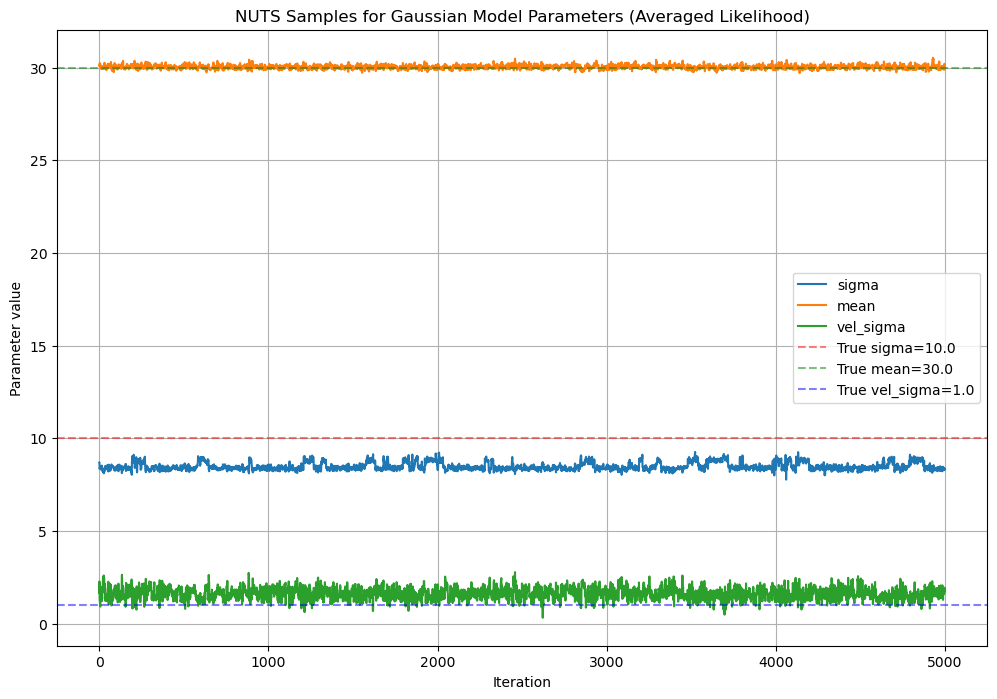

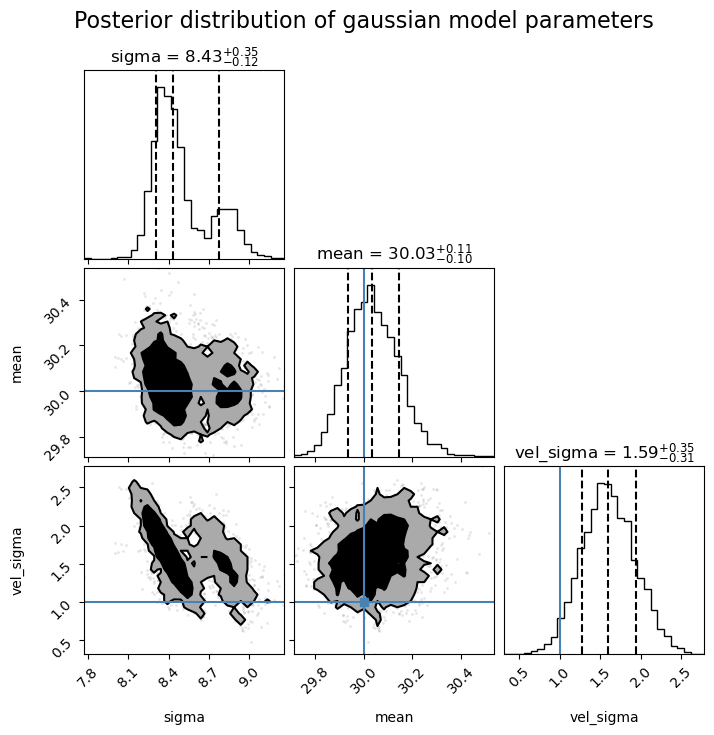

In [23]:
kernel = blackjax.nuts(log_posterior_avg, **parameters).step
states = inference_loop(sample_key, kernel, state, num_samples)

mcmc_samples = states.position

# Create trace plots
plt.figure(figsize=(12, 8))
plt.plot(mcmc_samples["sigma"], label="sigma")
plt.plot(mcmc_samples["mean"], label="mean")
plt.plot(mcmc_samples["vel_sigma"], label="vel_sigma")
plt.axhline(y=theta[0], color='r', linestyle='--', alpha=0.5, label=f'True sigma={theta[0]}')
plt.axhline(y=theta[1], color='g', linestyle='--', alpha=0.5, label=f'True mean={theta[1]}')
plt.axhline(y=theta[2], color='b', linestyle='--', alpha=0.5, label=f'True vel_sigma={theta[2]}')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.title('NUTS Samples for Gaussian Model Parameters (Averaged Likelihood)')
plt.legend()
plt.grid(True)
plt.show()

burnin = 1000
samples = np.column_stack([
    np.array(mcmc_samples["sigma"])[burnin:],
    np.array(mcmc_samples["mean"])[burnin:],
    np.array(mcmc_samples["vel_sigma"])[burnin:]
])

fig = corner.corner(
    samples, 
    labels=["sigma", "mean", "vel_sigma"],
    truths=theta,  # True parameter values
    show_titles=True, 
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],  # Show 68% intervals
    levels=(0.68, 0.95),  # 1-sigma and 2-sigma contours
    plot_contours=True,
    fill_contours=True,
    bins=30
)

fig.suptitle("Posterior distribution of gaussian model parameters", fontsize=16)
plt.subplots_adjust(top=0.90)
plt.show()